# MLB DFS Capstone - Modeling

<a id = 'contents'></a>

# Table of contents

<a href='#calc_target_var'>Calculating Target Variable</a><br>
<a href='#/PA_cols'>Creating Per-plate-appearance Features (and a quick primer on some derived features)</a><br>
<a href='#Handedness'>Handedness</a><br>
<a href='#Odds'>Odds</a><br>
<a href='#Opp_Pitch_Data'>Opposing Pitcher Data</a><br>
<a href='#Park_Factors'>Park Factors</a><br>
<a href='#temp_and_wind'>Temp and Wind</a><br>
<a href='#Fixing_Data_Types'>Fixing Data Types</a><br>
<a href='#Categorical'>Encoding Categorical Variables</a><br>
<a href='#Histogram'>Histogram of Features</a><br>
<a href='#Correlations'>Correlations</a><br>
<a href='#Train_Test'>Train-Test Split and Scaling</a><br>
<a href='#Models'>Regression Models</a><br>
<a href='#Classification Models'>Classification Models</a><br>
<a href='#Conclusion'>Conclusion</a><br>

# Summary
Our goal is to create a model that predicts points for hitters in daily fantasy baseball.<br>

We tried basic, out-of-the-box regression, then Lasso regression, then RandomForestRegressor with default parameters, then RandomForest with 10000 learners, max depth of 9 and max features of square root (we had about 100 features at the time and about 5500 observations). Then we tried Gradient Boosting with 625 learners, a 0.01 learning rate and max_depth of 6. This yielded the best results, although it wasn't much better than the LinearRegressor.<br>

The following Gradient Boosting results are from a previous notebook, as we made a copy of the notebook here to modify the dataset (more on that later).<br>

R2 Train Score: 0.5736191439720295<br>
R2 Test Score: 0.05744156524299726<br>
Mean Absolute Error: 5.408530686544012<br>
Mean Squared Error: 49.85027468592959<br>
Run time: 8.827581405639648<br>

An MAE of 5.4 might not seem that bad, but when most of the target scores are 14 points or less, it's not that great, and the R2 scores leave a lot to be desired.<br>

So we decided to alter our features a little bit. In addition to advanced analytical metrics like barrels, exit velocity and launch angle, we figured why not also look at the rate at which these players have actually been scoring fantasy points over the last 30 days. In trying to be so hyperanalytic, this seemed like obvious data that we overlooked during our data wrangling.<br>

That didn't make much of a difference. So we went the other way and pared our features all the way down to 35. That didn't work either. We tried everything with regression and couldn't come up with a suitable model. Our results are documented in the Models section of this notebook.<br>

Ultimately, we turned this into a binary classification problem. The target variable is binary, with the True class being players who hit at least one home run in that day's game.<br>

In [286]:
#Imports
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [287]:
#Reading in CSVs of each player's stats from last 30 days (FGBatters_L30) 
#and his live stats on current date (FGBattersFP)
list_of_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_df = pd.read_csv("FG_Batters_Last30_" + str(i) + ".csv")
    L30_df.drop(columns = ['Team', 'playerid'], inplace = True)
    L30_df.rename(columns= {'HR' : 'HR_L30', '1B': '1B_L30', '2B': '2B_L30', '3B': '3B_L30',\
                            'RBI': 'RBI_L30', 'R': 'R_L30', 'BB': 'BB_L30', 'SB': 'SB_L30', \
                            'HBP': 'HBP_L30'}, inplace = True)
    games_df = pd.read_csv("FGBattersFP_" + str(i) + ".csv")
    games_df = games_df[games_df['PA'] > 0]
    games_df.rename(columns = {'PA':'PA_Game'}, inplace = True)
    new_df = pd.merge(games_df, L30_df, how = 'left', on = 'Name')
    new_df.insert(0, 'Date', date_of_games)
    list_of_dfs.append(new_df)

In [288]:
#Creating our main dataframe by vertically concatenating the list of dataframes we created in previous cell.
main_df = pd.concat(list_of_dfs, ignore_index = True)

In [289]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+
0,2021-05-01,Jurickson Profar,SDP,1,0,0,0,1,1,1,...,46.0%,61.3%,8.1%,20.5%,50.7%,28.8%,37.0%,31.5%,31.5%,96.0
1,2021-05-01,Justin Williams,STL,1,0,0,0,1,2,1,...,37.7%,53.2%,13.4%,12.8%,48.7%,38.5%,28.2%,48.7%,23.1%,62.0
2,2021-05-01,Andy Young,ARI,1,0,0,0,1,1,1,...,32.1%,53.8%,17.0%,25.0%,0.0%,75.0%,0.0%,25.0%,75.0%,367.0
3,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,38.4%,49.0%,9.3%,29.4%,38.2%,32.4%,42.6%,33.8%,23.5%,186.0
4,2021-05-01,David Peralta,ARI,1,0,1,0,0,0,0,...,43.6%,52.4%,8.8%,13.3%,51.8%,34.9%,31.3%,41.0%,27.7%,123.0


In [290]:
main_df.tail()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+
8426,2021-08-29,Lars Nootbaar,STL,1,0,0,0,0,0,0,...,43.1%,59.2%,6.1%,15.2%,57.6%,27.3%,33.3%,39.4%,27.3%,173.0
8427,2021-08-29,Cal Raleigh,SEA,3,0,0,0,0,0,0,...,45.8%,72.7%,21.1%,20.5%,66.7%,12.8%,43.6%,30.8%,25.6%,37.0
8428,2021-08-29,Ryan Jeffers,MIN,4,0,0,0,0,0,0,...,37.6%,59.7%,13.1%,20.6%,38.2%,41.2%,44.1%,44.1%,11.8%,130.0
8429,2021-08-29,Sam Long,SFG,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8430,2021-08-29,Kwang-hyun Kim,STL,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8431 entries, 0 to 8430
Data columns (total 66 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        8431 non-null   datetime64[ns]
 1   Name        8431 non-null   object        
 2   Team        8431 non-null   object        
 3   PA_Game     8431 non-null   int64         
 4   1B          8431 non-null   int64         
 5   2B          8431 non-null   int64         
 6   3B          8431 non-null   int64         
 7   HR          8431 non-null   int64         
 8   RBI         8431 non-null   int64         
 9   R           8431 non-null   int64         
 10  BB          8431 non-null   int64         
 11  SB          8431 non-null   int64         
 12  HBP         8431 non-null   int64         
 13  playerid    8431 non-null   int64         
 14  PA          7830 non-null   float64       
 15  HR_L30      7830 non-null   float64       
 16  H           7830 non-nul

In [292]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PA_Game,8431.0,3.596845,1.365334,1.0,3.000,4.000,4.000,9.000
1B,8431.0,0.500297,0.689331,0.0,0.000,0.000,1.000,4.000
2B,8431.0,0.154786,0.395857,0.0,0.000,0.000,0.000,3.000
3B,8431.0,0.011505,0.107756,0.0,0.000,0.000,0.000,2.000
HR,8431.0,0.116000,0.345545,0.0,0.000,0.000,0.000,3.000
RBI,8431.0,0.416321,0.828232,0.0,0.000,0.000,1.000,7.000
R,8431.0,0.435891,0.674137,0.0,0.000,0.000,1.000,5.000
BB,8431.0,0.312181,0.564714,0.0,0.000,0.000,1.000,4.000
SB,8431.0,0.039972,0.207662,0.0,0.000,0.000,0.000,3.000
HBP,8431.0,0.043530,0.209791,0.0,0.000,0.000,0.000,2.000


In [293]:
#Dropping rows where plate appearances in that day's game are less than 3.
#If a player didn't appear at the plate at least three times there's a good chance he didn't start the game.
#A DFS player wouldn't knowingly roster a player who isn't starting.

main_df = main_df[main_df['PA_Game'] >= 3]

In [294]:
main_df.reset_index(drop=True, inplace=True)

In [295]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,38.4%,49.0%,9.3%,29.4%,38.2%,32.4%,42.6%,33.8%,23.5%,186.0
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,43.8%,59.6%,11.1%,12.5%,57.8%,29.7%,34.4%,31.3%,34.4%,101.0
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,35.8%,68.6%,18.8%,20.8%,40.3%,38.9%,40.3%,33.3%,26.4%,125.0
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,38.5%,55.1%,6.3%,18.4%,50.0%,31.6%,36.8%,34.2%,28.9%,144.0
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,44.5%,77.0%,11.4%,22.1%,54.5%,23.4%,33.8%,37.7%,28.6%,100.0


In [296]:
main_df.shape

(6728, 66)

In [297]:
#Dropping doubleheaders
doubleheader_dict = {'20210505': ['NYM', 'STL'], '20210529': ['COL', 'PIT', 'MIL', 'WSN', 'BAL', 'CHW'], \
                     '20210626': ['HOU', 'DET'], '20210630': ['DET', 'CLE'], '20210704': ['NYY', 'NYM'], \
                     '20210716': ['MIA', 'PHI'], '20210728': ['TOR', 'BOS'], '20210817': ['BOS', 'NYY'], \
                    '20210825': ['COL', 'CHC'], }

In [298]:
for key, value in doubleheader_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Team'].isin(value))), :]

In [299]:
main_df.shape

(6487, 66)

<a id='calc_target_var'></a>

# Calculating our target variable
But before we calculate our target variable, we're going to derive some features. Here, we take all the numbers that are used to calculate DraftKings points, but over the previous 30 days, as we mentioned in the initial report.<br>

Our target variable from here on out will only be DraftKings points. Initially, we wanted to predict both DraftKings and FanDuel points, but in our initial models we saw better results with DK. This reduces the confusion when we do our train-test split and type code for models later on.

In [300]:
#Calculating DraftKings points over the previous 30 days
main_df['DK_L30'] = (main_df['1B_L30'] * 3) + (main_df['2B_L30'] * 5) + (main_df['3B_L30'] * 8) + (main_df['HR_L30'] * 10) \
+ (main_df['RBI_L30'] * 2) + (main_df['R_L30'] * 2) + (main_df['BB_L30'] * 2) + (main_df['SB_L30'] * 5) + (main_df['HBP_L30'] * 2) 

In [301]:
#Calculating target variable. DraftKings points only this time, since we seem to be getting better model results with DK
main_df['DK_Pts'] = (main_df['1B'] * 3) + (main_df['2B'] * 5) + (main_df['3B'] * 8) + (main_df['HR'] * 10) \
+ (main_df['RBI'] * 2) + (main_df['R'] * 2) + (main_df['BB'] * 2) + (main_df['SB'] * 5) + (main_df['HBP'] * 2) 

In [302]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+,DK_L30,DK_Pts
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,9.3%,29.4%,38.2%,32.4%,42.6%,33.8%,23.5%,186.0,240.0,38
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,11.1%,12.5%,57.8%,29.7%,34.4%,31.3%,34.4%,101.0,182.0,33
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,18.8%,20.8%,40.3%,38.9%,40.3%,33.3%,26.4%,125.0,210.0,25
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,6.3%,18.4%,50.0%,31.6%,36.8%,34.2%,28.9%,144.0,95.0,26
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,11.4%,22.1%,54.5%,23.4%,33.8%,37.7%,28.6%,100.0,167.0,20


In [303]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Dropping columns used to calculate target variables
Now that we have DraftKings points calculated, there's really no need to lug the following columns through the rest of the project. They are used to calculate the player's fantasy points in that day's game and have no predictive use. Neither do that day's number of plate appearances ('PA_Game') and playerid.<br>

We will, however, keep home runs ('HR'). That's because while we are hoping to use regression to create a model that predicts DraftKings points for an observed slate of games, we realize that if we can't come up with better results to predict this continuous target variable, we'll have to turn this into a classification task. If we do that, the target variable would become binary: Will our player hit at least one home run?<br>

For now, we'll just drop the 'HR' column before creating the regression models, and then bring it back if we have to resort to classification.<br>

In [304]:
main_df.drop(columns = ['PA_Game', '1B', '2B', '3B', 'RBI', 'R', 'BB', 'SB', 'HBP', 'playerid'], inplace = True)

In [305]:
main_df.shape

(6487, 58)

In [306]:
#Now that we've dropped those columns, let's reuse these dropped names to rename the L30 columns
main_df.rename(columns = {'1B_L30': '1B', '2B_L30': '2B', '3B_L30': '3B',\
                          'RBI_L30': 'RBI', 'R_L30': 'R', 'BB_L30': 'BB', 'SB_L30' :'SB', 'HBP_L30': 'HBP'}, inplace = True)

In [307]:
#Reading in CSV of (hopefully) everyone who has pitched in 2021 so we can weed pitchers out of the batting statistics.
#Pitchers did bat in the National League through 2021, but were not available to be drafted as hitters.
pitchers = pd.read_csv('FG_Pitcher_Names_2021.csv')

In [308]:
pitchers.head()

,Name,Team,W,L,SV,G,GS,IP,K/9,BB/9,...,LOB%,GB%,HR/FB,vFA (pi),ERA,xERA,FIP,xFIP,WAR,playerid
0,Corbin Burnes,MIL,11,5,0,28,28,167.0,12.61,1.83,...,75.7%,48.8%,6.1%,96.5,2.43,2.01,1.63,2.30,7.5,19361
1,Zack Wheeler,PHI,14,10,0,32,32,213.1,10.42,1.94,...,75.3%,49.8%,10.8%,97.3,2.78,2.78,2.59,2.84,7.3,10310
2,Nathan Eovaldi,BOS,11,9,0,32,32,182.1,9.63,1.73,...,70.4%,42.0%,8.2%,97.1,3.75,3.37,2.79,3.48,5.6,9132
3,Walker Buehler,LAD,16,4,0,33,33,207.2,9.19,2.25,...,80.9%,44.7%,10.1%,95.5,2.47,3.08,3.15,3.57,5.5,19374
4,Max Scherzer,- - -,15,4,0,30,30,179.1,11.84,1.81,...,84.3%,33.5%,11.7%,94.5,2.46,2.89,2.97,3.24,5.4,3137


In [309]:
pitchers_names = list(pitchers['Name'])

In [310]:
for i in range(len(pitchers_names)):
    main_df = main_df.loc[main_df['Name'] != pitchers_names[i], :]
    

In [311]:
main_df.shape

(5905, 58)

In [312]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5905 entries, 0 to 6727
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5905 non-null   datetime64[ns]
 1   Name        5905 non-null   object        
 2   Team        5905 non-null   object        
 3   HR          5905 non-null   int64         
 4   PA          5811 non-null   float64       
 5   HR_L30      5811 non-null   float64       
 6   H           5811 non-null   float64       
 7   1B          5811 non-null   float64       
 8   2B          5811 non-null   float64       
 9   3B          5811 non-null   float64       
 10  RBI         5811 non-null   float64       
 11  BB          5811 non-null   float64       
 12  SB          5811 non-null   float64       
 13  HBP         5811 non-null   float64       
 14  R           5811 non-null   float64       
 15  Events      5811 non-null   float64       
 16  EV          5808 non-nul

In [313]:
#Assessing missing values. We'll end up dropping 114 rows.
main_df_with_nulls = main_df[main_df.isna().any(axis=1)]

In [314]:
main_df_with_nulls.head()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+,DK_L30,DK_Pts
124,2021-05-01,Yu-Cheng Chang,CLE,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
161,2021-05-01,Nate Lowe,TEX,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
234,2021-05-01,Austin Nola,SDP,0,4.0,0.0,0.0,0.0,0.0,0.0,...,7.1%,0.0%,33.3%,66.7%,33.3%,33.3%,33.3%,-100.0,0.0,0
247,2021-05-01,Daniel Johnson Jr.,CLE,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
316,2021-05-05,Nate Lowe,TEX,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [315]:
main_df_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 124 to 6725
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        114 non-null    datetime64[ns]
 1   Name        114 non-null    object        
 2   Team        114 non-null    object        
 3   HR          114 non-null    int64         
 4   PA          20 non-null     float64       
 5   HR_L30      20 non-null     float64       
 6   H           20 non-null     float64       
 7   1B          20 non-null     float64       
 8   2B          20 non-null     float64       
 9   3B          20 non-null     float64       
 10  RBI         20 non-null     float64       
 11  BB          20 non-null     float64       
 12  SB          20 non-null     float64       
 13  HBP         20 non-null     float64       
 14  R           20 non-null     float64       
 15  Events      20 non-null     float64       
 16  EV          17 non-null

In [316]:
main_df.isnull().sum().sum()

5052

In [317]:
main_df.dropna(inplace=True)
main_df.reset_index(drop=True, inplace = True)

In [318]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5791 non-null   datetime64[ns]
 1   Name        5791 non-null   object        
 2   Team        5791 non-null   object        
 3   HR          5791 non-null   int64         
 4   PA          5791 non-null   float64       
 5   HR_L30      5791 non-null   float64       
 6   H           5791 non-null   float64       
 7   1B          5791 non-null   float64       
 8   2B          5791 non-null   float64       
 9   3B          5791 non-null   float64       
 10  RBI         5791 non-null   float64       
 11  BB          5791 non-null   float64       
 12  SB          5791 non-null   float64       
 13  HBP         5791 non-null   float64       
 14  R           5791 non-null   float64       
 15  Events      5791 non-null   float64       
 16  EV          5791 non-nul

In [319]:
print(all(main_df))

True


In [320]:
main_df.describe()

,HR,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,...,OBP,OPS,ISO,BABIP,GB/FB,BsR,UBR,wRC+,DK_L30,DK_Pts
count,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,...,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000
mean,0.143153,81.877051,2.945087,18.706268,11.734243,3.740287,0.286652,10.122259,7.352271,1.075462,...,0.324264,0.751414,0.176351,0.296577,1.342535,0.019893,0.012554,103.118287,148.842514,7.333276
std,0.381870,31.021705,2.435650,8.817507,6.171191,2.555815,0.560988,6.028823,4.691509,1.705322,...,0.071893,0.199064,0.101107,0.086977,0.809944,0.625073,0.365034,51.319817,71.623192,7.377190
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.100000,-1.900000,-100.000000,0.000000,0.000000
25%,0.000000,62.000000,1.000000,12.000000,7.000000,2.000000,0.000000,6.000000,4.000000,0.000000,...,0.284000,0.634000,0.110000,0.250000,0.850000,-0.400000,-0.200000,74.000000,98.000000,2.000000
50%,0.000000,89.000000,2.000000,19.000000,12.000000,3.000000,0.000000,10.000000,7.000000,0.000000,...,0.326000,0.750000,0.167000,0.295000,1.160000,0.000000,0.000000,104.000000,149.000000,5.000000
75%,0.000000,107.000000,4.000000,25.000000,16.000000,5.000000,0.000000,14.000000,10.000000,2.000000,...,0.366000,0.860500,0.233000,0.343000,1.610000,0.300000,0.200000,132.000000,200.000000,11.000000
max,3.000000,144.000000,17.000000,45.000000,34.000000,16.000000,4.000000,40.000000,33.000000,20.000000,...,1.000000,3.000000,1.500000,1.000000,11.000000,5.100000,1.300000,699.000000,399.000000,56.000000


<a href = '#contents'>Back to Table of Contents</a>

<a id='/PA_cols'></a>

# Per-plate-appearance columns
A little more feature engineering. We're going to divide the last-30-day stats below by plate appearances over the last 30 days. Notice that HR and DK both still have L30 suffixes because we still have the HR and DK_Pts features for our observed games, the latter of which is our target variable.<br>

Just to clear up any confusion at this point, here's a quick look at some of the features that have similar names:<br>

**HR:** Home runs hit in a specific game on the observed date for which we are trying to predict DraftKings points. This will only be used if this turns into a classification model.<br>
**HR_L30:** Home runs hit over the previous 30 days.<br>
**DK_Pts:** Our target variable. DraftKings points scored in a specific game on the observed date.<br>
**DK_L30:** Total DraftKings points over the last 30 days.<br>
**HR_L30/PA:** Home runs per plate appearance over the previous 30 days.<br>
**DK_L30/PA:** DraftKings points per plate appearance over the previous 30 days.<br>

In [321]:
#Creating per-plate-appearance columns for last 30 days, dividing each of the following columns by PA
cols_to_engineer = ['HR_L30', 'H', '1B', '2B', '3B', 'RBI', 'BB', 'SB', 'HBP', 'R', 'DK_L30']

In [322]:
for i in range(len(cols_to_engineer)):
    new_name = cols_to_engineer[i] + '/PA'
    main_df[new_name] = main_df[cols_to_engineer[i]]/main_df['PA']

In [323]:
main_df.head()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,H/PA,1B/PA,2B/PA,3B/PA,RBI/PA,BB/PA,SB/PA,HBP/PA,R/PA,DK_L30/PA
0,2021-05-01,Jared Walsh,LAA,2,98.0,6.0,31.0,20.0,4.0,1.0,...,0.316327,0.204082,0.040816,0.010204,0.214286,0.081633,0.000000,0.030612,0.142857,2.448980
1,2021-05-01,Andrew Benintendi,KCR,2,94.0,3.0,21.0,14.0,4.0,0.0,...,0.223404,0.148936,0.042553,0.000000,0.106383,0.106383,0.042553,0.000000,0.159574,1.936170
2,2021-05-01,Salvador Perez,KCR,1,105.0,6.0,28.0,15.0,7.0,0.0,...,0.266667,0.142857,0.066667,0.000000,0.152381,0.038095,0.000000,0.009524,0.133333,2.000000
3,2021-05-01,Willie Calhoun,TEX,1,49.0,2.0,15.0,12.0,1.0,0.0,...,0.306122,0.244898,0.020408,0.000000,0.102041,0.061224,0.000000,0.020408,0.163265,1.938776
4,2021-05-01,Jeimer Candelario,DET,1,113.0,2.0,29.0,22.0,5.0,0.0,...,0.256637,0.194690,0.044248,0.000000,0.070796,0.079646,0.000000,0.000000,0.097345,1.477876


In [324]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 69 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5791 non-null   datetime64[ns]
 1   Name        5791 non-null   object        
 2   Team        5791 non-null   object        
 3   HR          5791 non-null   int64         
 4   PA          5791 non-null   float64       
 5   HR_L30      5791 non-null   float64       
 6   H           5791 non-null   float64       
 7   1B          5791 non-null   float64       
 8   2B          5791 non-null   float64       
 9   3B          5791 non-null   float64       
 10  RBI         5791 non-null   float64       
 11  BB          5791 non-null   float64       
 12  SB          5791 non-null   float64       
 13  HBP         5791 non-null   float64       
 14  R           5791 non-null   float64       
 15  Events      5791 non-null   float64       
 16  EV          5791 non-nul

In [325]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
HR,5791.0,0.143153,0.381870,0.0,0.000000,0.000000,0.000000,3.000
PA,5791.0,81.877051,31.021705,1.0,62.000000,89.000000,107.000000,144.000
HR_L30,5791.0,2.945087,2.435650,0.0,1.000000,2.000000,4.000000,17.000
H,5791.0,18.706268,8.817507,0.0,12.000000,19.000000,25.000000,45.000
1B,5791.0,11.734243,6.171191,0.0,7.000000,12.000000,16.000000,34.000
2B,5791.0,3.740287,2.555815,0.0,2.000000,3.000000,5.000000,16.000
3B,5791.0,0.286652,0.560988,0.0,0.000000,0.000000,0.000000,4.000
RBI,5791.0,10.122259,6.028823,0.0,6.000000,10.000000,14.000000,40.000
BB,5791.0,7.352271,4.691509,0.0,4.000000,7.000000,10.000000,33.000
SB,5791.0,1.075462,1.705322,0.0,0.000000,0.000000,2.000000,20.000


<a href='#contents'>Back to Table of Contents</a>

<a id='Handedness'></a>

# Handedness

In [326]:
#Reading in dataframes that break down handedness matchups,
#extracting the names and turning them into sets of left-handed and right-handed batters
#so we can distinguish between right-handed hitters, left-handed hitters and switch-hitters
batsrvr_df = pd.read_csv("FGBats_RvR.csv")
batslvr_df = pd.read_csv("FGBats_LvR.csv")
batsrvl_df = pd.read_csv("FGBats_RvL.csv")
batslvl_df = pd.read_csv("FGBats_LvL.csv")

In [327]:
print(len(batsrvr_df), len(batslvr_df), len(batsrvl_df), len(batslvl_df))

621 402 618 278


In [328]:
batsrvr_df = batsrvr_df[['Name']]
batslvr_df = batslvr_df[['Name']]
batsrvl_df = batsrvl_df[['Name']]
batslvl_df = batslvl_df[['Name']]

In [329]:
rvr_set = set(batsrvr_df['Name'])
rvl_set = set(batsrvl_df['Name'])
lvl_set = set(batslvl_df['Name'])
lvr_set= set(batslvr_df['Name'])

In [330]:
righties_set = rvr_set.union(rvl_set)
lefties_set = lvl_set.union(lvr_set)

In [331]:
righties_only = list(righties_set.difference(lefties_set))
lefties_only = list(lefties_set.difference(righties_set))
switch = list(righties_set.intersection(lefties_set))

In [332]:
conds = [main_df['Name'].isin(righties_only), main_df['Name'].isin(lefties_only), main_df['Name'].isin(switch)]
choices = ['R', 'L', 'S']

In [333]:
#Adding 'Bats' categorical variable
main_df['Bats'] = np.select(conds, choices)

In [334]:
main_df['Bats'].unique()

array(['L', 'R', 'S'], dtype=object)

In [335]:
missing_bat_hand = main_df[main_df['Bats'] == '0']

In [336]:
#We have 85 rows (45 unique players) with a '0' value for bat hand.
#Using Baseball Reference, we find the missing values
missing_bat_hand['Name'].unique()

array([], dtype=object)

In [337]:
len(missing_bat_hand)

0

In [338]:
# len(missing_bat_hand['Name'].unique())

In [339]:
# #Creating lists for left-handed hitters and switch-hitters. The rest of the hitters are right-handed.
# missing_lefties = ['Tony Wolters', 'Mason Williams', 'Estevan Florial', 'Rob Brantly', 'Matt Thaiss', 'Austin Allen']
# missing_switch = ['Max Moroff', 'Vidal Brujan', 'Taylor Gushue']

In [340]:
#main_df.columns.get_loc('Name')

In [341]:
#main_df.columns.get_loc('Bats')

In [342]:
#for i in range(len(main_df)):
#     if main_df.iloc[i, 69] == '0':
#         if main_df.iloc[i, 1] in missing_lefties:
#             main_df.iloc[i, 69] = 'L'
#         elif main_df.iloc[i, 1] in missing_switch:
#             main_df.iloc[i, 69] = 'S'
#         else:
#             main_df.iloc[i, 69] = 'R'

In [343]:
#main_df['Bats'].unique()

In [344]:
switch_hitters = main_df[main_df['Bats'] == 'S']
len(switch_hitters)

699

In [345]:
switch_hitters.sample(5)

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,1B/PA,2B/PA,3B/PA,RBI/PA,BB/PA,SB/PA,HBP/PA,R/PA,DK_L30/PA,Bats
3738,2021-07-20,Cesar Hernandez,CLE,0,98.0,4.0,20.0,11.0,5.0,0.0,...,0.112245,0.051020,0.0,0.112245,0.051020,0.000000,0.010204,0.112245,1.571429,S
1795,2021-06-06,Jorge Polanco,MIN,0,109.0,5.0,25.0,12.0,8.0,0.0,...,0.110092,0.073394,0.0,0.110092,0.110092,0.009174,0.000000,0.146789,1.935780,S
1699,2021-06-02,Jonah Heim,TEX,0,39.0,1.0,9.0,6.0,2.0,0.0,...,0.153846,0.051282,0.0,0.051282,0.076923,0.000000,0.000000,0.076923,1.384615,S
3773,2021-07-20,Vidal Brujan,TBR,0,17.0,0.0,1.0,1.0,0.0,0.0,...,0.058824,0.000000,0.0,0.058824,0.000000,0.058824,0.000000,0.058824,0.705882,S
4916,2021-08-13,Jonathan Villar,NYM,0,89.0,4.0,22.0,16.0,2.0,0.0,...,0.179775,0.022472,0.0,0.112360,0.067416,0.000000,0.000000,0.112360,1.685393,S


<a href='#contents'>Back to Table of Contents</a>

<a id='Odds'></a>

# Bringing in the Odds dataframe

In [346]:
odds_df = pd.read_excel("MLBOdds_1005.xlt")

In [347]:
odds_df.head()

,Date,VH,Team,Pitcher,Open,OpenOU
0,501,V,MIA,PCAMPBELL,105,8.5
1,501,H,WAS,PCORBIN-L,-125,8.5
2,501,V,CUB,ZDAVIES,135,9.0
3,501,H,CIN,LCASTILLO,-160,9.0
4,501,V,NYM,TWALKER,100,7.5


In [348]:
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     766 non-null    int64  
 1   VH       766 non-null    object 
 2   Team     766 non-null    object 
 3   Pitcher  766 non-null    object 
 4   Open     766 non-null    int64  
 5   OpenOU   766 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 36.0+ KB


In [349]:
team_codes = main_df['Team'].unique()

In [350]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA',
       'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG',
       'BAL', 'HOU', 'TBR'], dtype=object)

In [351]:
#Creating a dict by hand so that three-letter team codes in Odds match up with the ones in main_df
odds_team_dict = {'SDG':'SDP', 'CWS':'CHW', 'SFO':'SFG', 'KAN':'KCR', 'WAS': 'WSN', 'TAM': 'TBR', 'CUB': 'CHC'}

In [352]:
odds_df['Team'].replace(odds_team_dict, inplace = True)

In [353]:
odds_df.head(10)

,Date,VH,Team,Pitcher,Open,OpenOU
0,501,V,MIA,PCAMPBELL,105,8.5
1,501,H,WSN,PCORBIN-L,-125,8.5
2,501,V,CHC,ZDAVIES,135,9.0
3,501,H,CIN,LCASTILLO,-160,9.0
4,501,V,NYM,TWALKER,100,7.5
5,501,H,PHI,ZWHEELER,-120,7.5
6,501,V,STL,JFLAHERTY,-135,7.5
7,501,H,PIT,TCAHILL,115,7.5
8,501,V,LAD,DMAY,-115,7.0
9,501,H,MIL,BWOODRUFF,-105,7.0


In [354]:
#There's one game missing from odd_df. We found the info somewhere else.
newrow1 = {'Date': 626, 'VH':'V', 'Team': 'SEA', 'Pitcher': 'GILBERT', 'Open': 165, 'OpenOU': 8.0}

In [355]:
newrow2 = {'Date': 626, 'VH':'H', 'Team': 'CHW', 'Pitcher': 'LYNN', 'Open': -195, 'OpenOU': 8.0}

In [356]:
odds_df = odds_df.append([newrow1], ignore_index = True)

In [357]:
odds_df = odds_df.append([newrow2], ignore_index = True)

In [358]:
odds_df.tail()

,Date,VH,Team,Pitcher,Open,OpenOU
763,829,H,CHW,DCEASE,-210,8.5
764,829,V,MIL,AASHBY-L,-140,10.0
765,829,H,MIN,GJAX,120,10.0
766,626,V,SEA,GILBERT,165,8.0
767,626,H,CHW,LYNN,-195,8.0


In [359]:
#Making sure all visiting teams are in even-indexed rows and all home teams are in odd-indexed rows.
odds_df.iloc[0::2, 1].unique()

array(['V'], dtype=object)

In [360]:
odds_df.iloc[1::2, 1].unique()

array(['H'], dtype=object)

In [361]:
odds_df.drop(columns = 'VH', inplace = True)

In [362]:
#Function to create separate odds dataframes for home and visiting teams
def split_odds_df(first_row, first_col, last_col):
    """Splitting odds_df by home and visiting teams"""
    odds_df_split = odds_df.iloc[first_row::2, first_col:last_col]
    odds_df_split.reset_index(drop = True, inplace = True)
    return odds_df_split

In [363]:
odds_df_v = split_odds_df(0, 0, -1)

In [364]:
odds_df_v.head()

,Date,Team,Pitcher,Open
0,501,MIA,PCAMPBELL,105
1,501,CHC,ZDAVIES,135
2,501,NYM,TWALKER,100
3,501,STL,JFLAHERTY,-135
4,501,LAD,DMAY,-115


In [365]:
#Adding V_ prefixes
odds_df_v.rename(columns = {'Team': 'V_Team', 'Pitcher': 'V_Pitcher', 'Open': 'V_Open'}, inplace = True)

In [366]:
odds_df_v.head()

,Date,V_Team,V_Pitcher,V_Open
0,501,MIA,PCAMPBELL,105
1,501,CHC,ZDAVIES,135
2,501,NYM,TWALKER,100
3,501,STL,JFLAHERTY,-135
4,501,LAD,DMAY,-115


In [367]:
odds_df_h = split_odds_df(1, 1, 5)

In [368]:
odds_df_h.head()

,Team,Pitcher,Open,OpenOU
0,WSN,PCORBIN-L,-125,8.5
1,CIN,LCASTILLO,-160,9.0
2,PHI,ZWHEELER,-120,7.5
3,PIT,TCAHILL,115,7.5
4,MIL,BWOODRUFF,-105,7.0


In [369]:
#Adding H_ prefixes
odds_df_h.rename(columns = {'Team':'H_Team', 'Pitcher':'H_Pitcher', 'Open': 'H_Open'}, inplace = True)

In [370]:
odds_df_h.head()

,H_Team,H_Pitcher,H_Open,OpenOU
0,WSN,PCORBIN-L,-125,8.5
1,CIN,LCASTILLO,-160,9.0
2,PHI,ZWHEELER,-120,7.5
3,PIT,TCAHILL,115,7.5
4,MIL,BWOODRUFF,-105,7.0


In [371]:
odds_df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       384 non-null    int64 
 1   V_Team     384 non-null    object
 2   V_Pitcher  384 non-null    object
 3   V_Open     384 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.1+ KB


In [372]:
odds_df_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   H_Team     384 non-null    object 
 1   H_Pitcher  384 non-null    object 
 2   H_Open     384 non-null    int64  
 3   OpenOU     384 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 12.1+ KB


In [373]:
#Joining the dataframes we just created 
#so that now we have a single row for every game, with info for both visiting and home teams.
odds_df_all = odds_df_v.join(odds_df_h, how = 'left')

In [374]:
odds_df_all.head(10)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0
5,501,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0
6,501,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0
7,501,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0
8,501,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0
9,501,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5


In [375]:
#Adding win probability columns and setting to 0.5. Will be adjusted according to money lines.
odds_df_all['V_Win_Prob'] = .5
odds_df_all['H_Win_Prob'] = .5

In [376]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.5,0.5
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.5,0.5
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.5,0.5
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.5,0.5
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.5,0.5


In [377]:
def create_win_prob(df, col1, col2):
    """Algorithm to process money lines"""
    for i in range(len(df)):
        moneyline = df.iloc[i, col1]
        overunder = df.iloc[i, 7]
        if moneyline < -300:
            df.iloc[i, col2] = .75
        elif moneyline > 300:
            df.iloc[i, col2] = .25
        else:
            if moneyline < 0:
                moneyline = moneyline + 100
            else:
                moneyline = moneyline - 100
            moneyline = moneyline + 200
            win_prob = .75 - moneyline * .00125
            df.iloc[i, col2] = win_prob

In [378]:
create_win_prob(odds_df_all, 3, 8)
create_win_prob(odds_df_all, 6, 9)
#create_proj_runs(odds_df_all, 3, 8)
#create_proj_runs(odds_df_all, 6, 9)

In [379]:
#Adding a prob_total column to make sure our win probabilities add up to 1
odds_df_all['prob_total'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob']

In [380]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_total
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.49375,0.53125,1.02500
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.45625,0.57500,1.03125
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.50000,0.52500,1.02500
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.54375,0.48125,1.02500
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.51875,0.50625,1.02500


In [381]:
#Since most of these win probabilities add up to a number greater than 1,
#we take the overset, split it and subtract equally from both H_Win_Prob and V_Win_Prob
odds_df_all['prob_overset'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob'] - 1
odds_df_all['V_Win_Prob'] = odds_df_all['V_Win_Prob'] - odds_df_all['prob_overset'] / 2
odds_df_all['H_Win_Prob'] = odds_df_all['H_Win_Prob'] - odds_df_all['prob_overset'] / 2

In [382]:
odds_df_all['prob_total'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob']

# This is strange
It seems all the values of the prob_total column are 1.0, but .value_counts lists them as different values. Our best guess here is that one of these 1.0 values is actually 1. followed by several zeroes and then a number. We figure we got the job done here by getting all the probability totals to 1 or a number very close to it.

In [383]:
odds_df_all['prob_total'].value_counts()

1.0    356
1.0     28
Name: prob_total, dtype: int64

In [384]:
#Dropping the columns we used to calculate win probability for each team
odds_df_all.drop(columns = ['prob_total', 'prob_overset'], inplace = True)

In [385]:
#Multiplying win probabilities by over-under to get projected run totals
odds_df_all['V_Proj_Runs'] = odds_df_all['V_Win_Prob'] * odds_df_all['OpenOU']

In [386]:
odds_df_all['H_Proj_Runs'] = odds_df_all['H_Win_Prob'] * odds_df_all['OpenOU']

In [387]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,4.090625,4.409375
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,3.965625,5.034375
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,3.656250,3.843750
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,3.984375,3.515625
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,3.543750,3.456250


In [388]:
#Adding ballpark column to odds_df_all by copying H_Team 
#since the game is being played in the ballpark of the home team.
#We'll be adding ballpark factors later
odds_df_all['Park'] = odds_df_all['H_Team']

In [389]:
#Because of COVID restrictions, the Blue Jays couldn't play in their home park until August.
#We'll create a list of the six dates that we need to change from 'TOR' to 'BUF' in the Park column
#Blue Jays home games
# May 1 Dunedin
# MAy 21 Dunedin
# June 2 Buffalo
# June 6 Buffalo
# June 26 Buffalo
# June 30 Buffalo
# July 4 Buffalo
# July 16 Buffalo
# Aug 1 Toronto
# Aug 5 Toronto
# Aug 21 Toronto
# Aug 25 Toronto 
tor_buf_dates = [602, 606, 626, 630, 704, 716]

In [390]:
odds_df_all[(odds_df_all['Date'].isin(tor_buf_dates)) & (odds_df_all['Park'] == 'TOR')]

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs,Park
112,602,MIA,PLOPEZ,130,TOR,AMANOAH,-150,8.5,0.450000,0.550000,3.825000,4.675000,TOR
122,606,HOU,LGARCIA,100,TOR,SMATZ-L,-120,10.0,0.487500,0.512500,4.875000,5.125000,TOR
188,626,BAL,KAKIN-L,220,TOR,HRYU-L,-270,10.0,0.318750,0.681250,3.187500,6.812500,TOR
200,630,SEA,JSHEFFIEL-L,155,TOR,SMATZ-L,-185,10.5,0.412500,0.587500,4.331250,6.168750,TOR
213,704,TBR,RYARBROUG-L,135,TOR,RRAY-L,-160,9.5,0.440625,0.559375,4.185937,5.314062,TOR
236,716,TEX,JLYLES,190,TOR,RRAY-L,-235,10.0,0.359375,0.640625,3.593750,6.406250,TOR


In [391]:
indexes_to_change = [112, 122, 188, 200, 213, 236]

In [392]:
odds_df_all.iloc[indexes_to_change, 12] = 'BUF'

In [393]:
odds_df_all.iloc[indexes_to_change, :]

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs,Park
112,602,MIA,PLOPEZ,130,TOR,AMANOAH,-150,8.5,0.450000,0.550000,3.825000,4.675000,BUF
122,606,HOU,LGARCIA,100,TOR,SMATZ-L,-120,10.0,0.487500,0.512500,4.875000,5.125000,BUF
188,626,BAL,KAKIN-L,220,TOR,HRYU-L,-270,10.0,0.318750,0.681250,3.187500,6.812500,BUF
200,630,SEA,JSHEFFIEL-L,155,TOR,SMATZ-L,-185,10.5,0.412500,0.587500,4.331250,6.168750,BUF
213,704,TBR,RYARBROUG-L,135,TOR,RRAY-L,-160,9.5,0.440625,0.559375,4.185937,5.314062,BUF
236,716,TEX,JLYLES,190,TOR,RRAY-L,-235,10.0,0.359375,0.640625,3.593750,6.406250,BUF


In [394]:
#Changing dates to datetime type
odds_df_all.Date = odds_df_all.Date.astype(str)

In [395]:
odds_df_all['Date'] = '20210' + odds_df_all['Date'] 

In [396]:
odds_df_all['Date'] = pd.to_datetime(odds_df_all['Date'], format = '%Y%m%d')

In [397]:
#Creating opposing hand columns 
#If last two characters in name of pitcher are '-L', the pitcher is left-handed
#Also creating 'V_Opp_Team' and 'H_Opp_Team' columns to indicate each team's opponent.
odds_df_all['H_Opp_Hand'] = np.where(odds_df_all['V_Pitcher'].str[-2:] == '-L', 'L', 'R')
odds_df_all['H_Opp_Pitcher'] = odds_df_all['V_Pitcher']
odds_df_all['H_Opp_Team'] = odds_df_all['V_Team']

In [398]:
odds_df_all['V_Opp_Hand'] = np.where(odds_df_all['H_Pitcher'].str[-2:] == '-L', 'L', 'R')
odds_df_all['V_Opp_Pitcher'] = odds_df_all['H_Pitcher']
odds_df_all['V_Opp_Team'] = odds_df_all['H_Team']

In [399]:
odds_df_all.head(10)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs,Park,H_Opp_Hand,H_Opp_Pitcher,H_Opp_Team,V_Opp_Hand,V_Opp_Pitcher,V_Opp_Team
0,2021-05-01,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,4.090625,4.409375,WSN,R,PCAMPBELL,MIA,L,PCORBIN-L,WSN
1,2021-05-01,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,3.965625,5.034375,CIN,R,ZDAVIES,CHC,R,LCASTILLO,CIN
2,2021-05-01,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,3.656250,3.843750,PHI,R,TWALKER,NYM,R,ZWHEELER,PHI
3,2021-05-01,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,3.984375,3.515625,PIT,R,JFLAHERTY,STL,R,TCAHILL,PIT
4,2021-05-01,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,3.543750,3.456250,MIL,R,DMAY,LAD,R,BWOODRUFF,MIL
5,2021-05-01,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0,0.418750,0.581250,3.350000,4.650000,ARI,L,AGOMBER-L,COL,R,ZGALLEN,ARI
6,2021-05-01,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0,0.428125,0.571875,2.996875,4.003125,SDP,R,ADESCLAFA,SFG,L,BSNELL-L,SDP
7,2021-05-01,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0,0.384375,0.615625,3.075000,4.925000,NYY,R,STURNBULL,DET,R,JTAILLON,NYY
8,2021-05-01,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0,0.493750,0.506250,4.443750,4.556250,MIN,L,DDUFFY-L,KCR,R,MSHOEMAKE,MIN
9,2021-05-01,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5,0.428125,0.571875,3.639062,4.860938,CHW,R,TMCKENZIE,CLE,R,LLYNN,CHW


In [400]:
#Breaking down odds_df_all back into specific rows for each team to prepare it for merging with main_df
#Renaming columns without 'V_' and 'H_' prefixes
odds_df_visitors = odds_df_all[['Date', 'V_Team', 'V_Proj_Runs', 'OpenOU', \
                                'V_Opp_Hand', 'V_Opp_Pitcher', 'V_Opp_Team', 'Park']].copy()
odds_df_visitors.rename(columns = {'V_Team':'Team', 'V_Proj_Runs':'Proj_Runs', \
                                   'V_Opp_Hand':'Opp_Hand', 'V_Opp_Pitcher': 'Opp_Pitcher',\
                                  'V_Opp_Team' : 'Opp_Team'}, inplace = True)
odds_df_home = odds_df_all[['Date', 'H_Team', 'H_Proj_Runs', 'OpenOU', \
                            'H_Opp_Hand', 'H_Opp_Pitcher', 'H_Opp_Team', 'Park']].copy()
odds_df_home.rename(columns = {'H_Team':'Team', 'H_Proj_Runs':'Proj_Runs', \
                               'H_Opp_Hand':'Opp_Hand', 'H_Opp_Pitcher': 'Opp_Pitcher',\
                              'H_Opp_Team' : 'Opp_Team'}, inplace = True)

In [401]:
odds_df_visitors.head()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,MIA,4.090625,8.5,L,PCORBIN-L,WSN,WSN
1,2021-05-01,CHC,3.965625,9.0,R,LCASTILLO,CIN,CIN
2,2021-05-01,NYM,3.656250,7.5,R,ZWHEELER,PHI,PHI
3,2021-05-01,STL,3.984375,7.5,R,TCAHILL,PIT,PIT
4,2021-05-01,LAD,3.543750,7.0,R,BWOODRUFF,MIL,MIL


In [402]:
odds_df_visitors.tail()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
379,2021-08-29,KCR,3.639062,8.5,L,MGONZALES-L,SEA,SEA
380,2021-08-29,NYY,4.893750,9.0,R,PBLACKBUR,OAK,OAK
381,2021-08-29,CHC,3.267188,8.5,R,DCEASE,CHW,CHW
382,2021-08-29,MIL,5.375000,10.0,R,GJAX,MIN,MIN
383,2021-06-26,SEA,3.200000,8.0,R,LYNN,CHW,CHW


In [403]:
odds_df_home.head()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,WSN,4.409375,8.5,R,PCAMPBELL,MIA,WSN
1,2021-05-01,CIN,5.034375,9.0,R,ZDAVIES,CHC,CIN
2,2021-05-01,PHI,3.843750,7.5,R,TWALKER,NYM,PHI
3,2021-05-01,PIT,3.515625,7.5,R,JFLAHERTY,STL,PIT
4,2021-05-01,MIL,3.456250,7.0,R,DMAY,LAD,MIL


In [404]:
odds_df_home.tail()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
379,2021-08-29,SEA,4.860938,8.5,R,BSINGER,KCR,SEA
380,2021-08-29,OAK,4.106250,9.0,L,JMONTGOME-L,NYY,OAK
381,2021-08-29,CHW,5.232812,8.5,R,KHENDRICK,CHC,CHW
382,2021-08-29,MIN,4.625000,10.0,L,AASHBY-L,MIL,MIN
383,2021-06-26,CHW,4.800000,8.0,R,GILBERT,SEA,CHW


In [405]:
odds_df_ready = pd.concat([odds_df_visitors, odds_df_home], ignore_index = True)

In [406]:
odds_df_ready.head(20)

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,MIA,4.090625,8.5,L,PCORBIN-L,WSN,WSN
1,2021-05-01,CHC,3.965625,9.0,R,LCASTILLO,CIN,CIN
2,2021-05-01,NYM,3.656250,7.5,R,ZWHEELER,PHI,PHI
3,2021-05-01,STL,3.984375,7.5,R,TCAHILL,PIT,PIT
4,2021-05-01,LAD,3.543750,7.0,R,BWOODRUFF,MIL,MIL
5,2021-05-01,COL,3.350000,8.0,R,ZGALLEN,ARI,ARI
6,2021-05-01,SFG,2.996875,7.0,L,BSNELL-L,SDP,SDP
7,2021-05-01,DET,3.075000,8.0,R,JTAILLON,NYY,NYY
8,2021-05-01,KCR,4.443750,9.0,R,MSHOEMAKE,MIN,MIN
9,2021-05-01,CLE,3.639062,8.5,R,LLYNN,CHW,CHW


In [407]:
odds_df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         768 non-null    datetime64[ns]
 1   Team         768 non-null    object        
 2   Proj_Runs    768 non-null    float64       
 3   OpenOU       768 non-null    float64       
 4   Opp_Hand     768 non-null    object        
 5   Opp_Pitcher  768 non-null    object        
 6   Opp_Team     768 non-null    object        
 7   Park         768 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 48.1+ KB


In [408]:
#Merging with main_df
#Now each individual player will have all of his matching team's data from the odds column
main_df = main_df.merge(odds_df_ready, on = ['Date', 'Team'], how = 'left')

In [409]:
main_df.head()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,HBP/PA,R/PA,DK_L30/PA,Bats,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,Jared Walsh,LAA,2,98.0,6.0,31.0,20.0,4.0,1.0,...,0.030612,0.142857,2.448980,L,4.568750,8.5,R,LNEWSOME,SEA,SEA
1,2021-05-01,Andrew Benintendi,KCR,2,94.0,3.0,21.0,14.0,4.0,0.0,...,0.000000,0.159574,1.936170,L,4.443750,9.0,R,MSHOEMAKE,MIN,MIN
2,2021-05-01,Salvador Perez,KCR,1,105.0,6.0,28.0,15.0,7.0,0.0,...,0.009524,0.133333,2.000000,R,4.443750,9.0,R,MSHOEMAKE,MIN,MIN
3,2021-05-01,Willie Calhoun,TEX,1,49.0,2.0,15.0,12.0,1.0,0.0,...,0.020408,0.163265,1.938776,L,3.559375,8.5,L,ERODRIGUE-L,BOS,TEX
4,2021-05-01,Jeimer Candelario,DET,1,113.0,2.0,29.0,22.0,5.0,0.0,...,0.000000,0.097345,1.477876,S,3.075000,8.0,R,JTAILLON,NYY,NYY


In [410]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 0 to 5790
Data columns (total 76 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5791 non-null   datetime64[ns]
 1   Name         5791 non-null   object        
 2   Team         5791 non-null   object        
 3   HR           5791 non-null   int64         
 4   PA           5791 non-null   float64       
 5   HR_L30       5791 non-null   float64       
 6   H            5791 non-null   float64       
 7   1B           5791 non-null   float64       
 8   2B           5791 non-null   float64       
 9   3B           5791 non-null   float64       
 10  RBI          5791 non-null   float64       
 11  BB           5791 non-null   float64       
 12  SB           5791 non-null   float64       
 13  HBP          5791 non-null   float64       
 14  R            5791 non-null   float64       
 15  Events       5791 non-null   float64       
 16  EV    

In [411]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [412]:
null_data

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,HBP/PA,R/PA,DK_L30/PA,Bats,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park


In [413]:
main_df.describe()

,HR,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,...,2B/PA,3B/PA,RBI/PA,BB/PA,SB/PA,HBP/PA,R/PA,DK_L30/PA,Proj_Runs,OpenOU
count,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,...,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000,5791.000000
mean,0.143153,81.877051,2.945087,18.706268,11.734243,3.740287,0.286652,10.122259,7.352271,1.075462,...,0.044904,0.003471,0.120700,0.088466,0.012816,0.011540,0.125004,1.778132,4.390401,8.770851
std,0.381870,31.021705,2.435650,8.817507,6.171191,2.555815,0.560988,6.028823,4.691509,1.705322,...,0.031351,0.007727,0.061401,0.047872,0.021483,0.016082,0.049590,0.505787,0.824831,0.954348
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.746875,6.000000
25%,0.000000,62.000000,1.000000,12.000000,7.000000,2.000000,0.000000,6.000000,4.000000,0.000000,...,0.026087,0.000000,0.081081,0.057143,0.000000,0.000000,0.094737,1.471804,3.843750,8.000000
50%,0.000000,89.000000,2.000000,19.000000,12.000000,3.000000,0.000000,10.000000,7.000000,0.000000,...,0.042105,0.000000,0.116505,0.083333,0.000000,0.008475,0.125000,1.760000,4.334375,9.000000
75%,0.000000,107.000000,4.000000,25.000000,16.000000,5.000000,0.000000,14.000000,10.000000,2.000000,...,0.060606,0.000000,0.156386,0.115385,0.018519,0.017857,0.153846,2.065217,4.875000,9.500000
max,3.000000,144.000000,17.000000,45.000000,34.000000,16.000000,4.000000,40.000000,33.000000,20.000000,...,1.000000,0.125000,1.000000,0.500000,0.400000,0.200000,1.000000,7.500000,7.356250,12.500000


<a href='#contents'>Back to Table of Contents</a>

<a id='Opp_Pitch_Data'></a>

# Bringing in pitching data
During EDA, we had a markdown cell titled "Data Wrangling is now closed."<br>
<br>
Famous last words.<br>
<br>
It turns out we needed more data. We went back to FanGraphs and found each team's starting pitcher for each of our 30 observed dates, and merging that on Name and Team with a dataframe of last-30-days hitting stats against every possible pitcher.<br>
<br>
So now the strength of each hitter's opposing starting pitcher will be accounted for in the features.

In [414]:
list_of_SP_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    SP_names_df = pd.read_csv("FG_SP_Names_" + str(i) + ".csv")
    SP_names_df = SP_names_df[['Name', 'Team']]
    SP_L30_df = pd.read_csv("FG_AllPitchers_L30_" + str(i) + ".csv")
    new_SP_df = pd.merge(SP_names_df, SP_L30_df, how = 'left', on = ['Name', 'Team'])
    new_SP_df.insert(0, 'Date', date_of_games)
    list_of_SP_dfs.append(new_SP_df)

In [415]:
SP_df = pd.concat(list_of_SP_dfs, ignore_index = True)

In [416]:
SP_df.head()

,Date,Name,Team,GS,IP,K/9,K%,BB/9,HR/9,BB%,...,Hard%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,playerid
0,2021-05-01,Griffin Canning,LAA,3.0,15.0,10.20,25.8%,3.00,3.60,7.6%,...,25.6%,89.2,10.6,5.0,11.4%,111.3,17.0,38.6%,44.0,19867.0
1,2021-05-01,Jack Flaherty,STL,5.0,28.1,8.58,23.9%,2.54,0.95,7.1%,...,28.0%,91.5,15.4,6.0,8.0%,113.2,31.0,41.3%,75.0,17479.0
2,2021-05-01,Jose Urquidy,HOU,5.0,27.0,7.33,19.5%,2.33,1.33,6.2%,...,28.9%,87.8,25.8,8.0,9.6%,107.7,28.0,33.7%,83.0,18413.0
3,2021-05-01,Zack Wheeler,PHI,5.0,31.2,9.95,27.8%,3.13,1.14,8.7%,...,29.1%,89.4,15.0,5.0,6.3%,114.1,29.0,36.7%,79.0,10310.0
4,2021-05-01,Luis Castillo,CIN,5.0,24.1,7.03,17.1%,2.59,1.85,6.3%,...,20.5%,90.0,5.4,7.0,8.4%,109.4,31.0,37.3%,83.0,15689.0


In [417]:
SP_df.shape

(812, 29)

In [418]:
SP_df.tail()

,Date,Name,Team,GS,IP,K/9,K%,BB/9,HR/9,BB%,...,Hard%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,playerid
807,2021-08-29,Eli Morgan,CLE,5.0,27.1,8.23,21.4%,2.96,0.66,7.7%,...,27.2%,89.1,20.2,8.0,9.9%,115.2,33.0,40.7%,81.0,20203.0
808,2021-08-29,Matthew Boyd,DET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809,2021-08-29,Griffin Jax,MIN,5.0,27.0,6.33,16.5%,3.33,2.33,8.7%,...,43.5%,90.2,16.6,9.0,10.6%,111.1,36.0,42.4%,85.0,20253.0
810,2021-08-29,Spenser Watkins,BAL,5.0,21.2,5.82,13.1%,2.91,1.66,6.5%,...,37.6%,91.1,13.0,10.0,11.8%,115.2,34.0,40.0%,85.0,17489.0
811,2021-08-29,Kyle Hendricks,CHC,5.0,30.0,6.60,16.5%,2.40,0.90,6.0%,...,26.0%,83.7,8.7,4.0,4.0%,107.0,26.0,26.0%,100.0,12049.0


In [419]:
SP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      812 non-null    datetime64[ns]
 1   Name      812 non-null    object        
 2   Team      812 non-null    object        
 3   GS        782 non-null    float64       
 4   IP        782 non-null    float64       
 5   K/9       782 non-null    float64       
 6   K%        782 non-null    object        
 7   BB/9      782 non-null    float64       
 8   HR/9      782 non-null    float64       
 9   BB%       782 non-null    object        
 10  BABIP     782 non-null    float64       
 11  HR/FB     782 non-null    object        
 12  SIERA     782 non-null    float64       
 13  FIP       782 non-null    float64       
 14  GB%       782 non-null    object        
 15  LD%       782 non-null    object        
 16  FB%       782 non-null    object        
 17  Soft%     782 no

In [420]:
SP_df.columns

Index(['Date', 'Name', 'Team', 'GS', 'IP', 'K/9', 'K%', 'BB/9', 'HR/9', 'BB%',
       'BABIP', 'HR/FB', 'SIERA', 'FIP', 'GB%', 'LD%', 'FB%', 'Soft%', 'Med%',
       'Hard%', 'EV', 'LA', 'Barrels', 'Barrel%', 'maxEV', 'HardHit',
       'HardHit%', 'Events', 'playerid'],
      dtype='object')

In [421]:
#Adding 'SP_' prefixes to column names to denote that these are features for starting pitchers.
new_SP_names = {'Name': 'Pitcher', 'Team': 'Opp_Team', 'K/9': 'SP_K/9', 'K%': 'SP_K%', 'BB/9': 'SP_BB/9', 'HR/9': 'SP_HR/9', 'BB%': 'SP_BB%',\
                'BABIP': 'SP_BABIP', 'GB%': 'SP_GB%', 'HR/FB': 'SP_HR/FB', 'FIP': 'SP_FIP', 'LD%': 'SP_LD%', \
                'FB%': 'SP_FB%', 'SIERA': 'SP_SIERA', 'Soft%': 'SP_Soft%', 'Med%': 'SP_Med%', 'Hard%' :'SP_Hard%', \
                'EV': 'SP_EV', 'LA': 'SP_LA', 'Barrels': 'SP_Barrels', 'Barrel%': 'SP_Barrel%', 'maxEV': 'SP_maxEV', \
                'HardHit': 'SP_HardHit', 'HardHit%': 'SP_HardHit%', 'Events': 'SP_Events'}

In [422]:
SP_df.rename(columns = new_SP_names, inplace = True)

In [423]:
SP_df.head()

,Date,Pitcher,Opp_Team,GS,IP,SP_K/9,SP_K%,SP_BB/9,SP_HR/9,SP_BB%,...,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events,playerid
0,2021-05-01,Griffin Canning,LAA,3.0,15.0,10.20,25.8%,3.00,3.60,7.6%,...,25.6%,89.2,10.6,5.0,11.4%,111.3,17.0,38.6%,44.0,19867.0
1,2021-05-01,Jack Flaherty,STL,5.0,28.1,8.58,23.9%,2.54,0.95,7.1%,...,28.0%,91.5,15.4,6.0,8.0%,113.2,31.0,41.3%,75.0,17479.0
2,2021-05-01,Jose Urquidy,HOU,5.0,27.0,7.33,19.5%,2.33,1.33,6.2%,...,28.9%,87.8,25.8,8.0,9.6%,107.7,28.0,33.7%,83.0,18413.0
3,2021-05-01,Zack Wheeler,PHI,5.0,31.2,9.95,27.8%,3.13,1.14,8.7%,...,29.1%,89.4,15.0,5.0,6.3%,114.1,29.0,36.7%,79.0,10310.0
4,2021-05-01,Luis Castillo,CIN,5.0,24.1,7.03,17.1%,2.59,1.85,6.3%,...,20.5%,90.0,5.4,7.0,8.4%,109.4,31.0,37.3%,83.0,15689.0


In [424]:
#Dropping rows with missing data
SP_df.dropna(inplace=True)

In [425]:
SP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 811
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         782 non-null    datetime64[ns]
 1   Pitcher      782 non-null    object        
 2   Opp_Team     782 non-null    object        
 3   GS           782 non-null    float64       
 4   IP           782 non-null    float64       
 5   SP_K/9       782 non-null    float64       
 6   SP_K%        782 non-null    object        
 7   SP_BB/9      782 non-null    float64       
 8   SP_HR/9      782 non-null    float64       
 9   SP_BB%       782 non-null    object        
 10  SP_BABIP     782 non-null    float64       
 11  SP_HR/FB     782 non-null    object        
 12  SP_SIERA     782 non-null    float64       
 13  SP_FIP       782 non-null    float64       
 14  SP_GB%       782 non-null    object        
 15  SP_LD%       782 non-null    object        
 16  SP_FB%  

In [426]:
SP_df.drop(columns = ['GS', 'IP', 'playerid'], inplace = True)

In [427]:
SP_df.head()

,Date,Pitcher,Opp_Team,SP_K/9,SP_K%,SP_BB/9,SP_HR/9,SP_BB%,SP_BABIP,SP_HR/FB,...,SP_Med%,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events
0,2021-05-01,Griffin Canning,LAA,10.20,25.8%,3.00,3.60,7.6%,0.289,35.3%,...,60.5%,25.6%,89.2,10.6,5.0,11.4%,111.3,17.0,38.6%,44.0
1,2021-05-01,Jack Flaherty,STL,8.58,23.9%,2.54,0.95,7.1%,0.222,10.7%,...,58.7%,28.0%,91.5,15.4,6.0,8.0%,113.2,31.0,41.3%,75.0
2,2021-05-01,Jose Urquidy,HOU,7.33,19.5%,2.33,1.33,6.2%,0.291,9.8%,...,47.0%,28.9%,87.8,25.8,8.0,9.6%,107.7,28.0,33.7%,83.0
3,2021-05-01,Zack Wheeler,PHI,9.95,27.8%,3.13,1.14,8.7%,0.267,14.3%,...,54.4%,29.1%,89.4,15.0,5.0,6.3%,114.1,29.0,36.7%,79.0
4,2021-05-01,Luis Castillo,CIN,7.03,17.1%,2.59,1.85,6.3%,0.346,25.0%,...,66.3%,20.5%,90.0,5.4,7.0,8.4%,109.4,31.0,37.3%,83.0


In [428]:
#Merging with main_df
main_df = main_df.merge(SP_df, on = ['Date', 'Opp_Team'], how = 'left')

In [429]:
main_df.head()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,SP_Med%,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events
0,2021-05-01,Jared Walsh,LAA,2,98.0,6.0,31.0,20.0,4.0,1.0,...,40.6%,37.5%,90.2,15.1,1.0,3.0%,108.5,12.0,36.4%,33.0
1,2021-05-01,Andrew Benintendi,KCR,2,94.0,3.0,21.0,14.0,4.0,0.0,...,51.5%,27.3%,89.6,15.8,8.0,12.1%,111.5,25.0,37.9%,66.0
2,2021-05-01,Salvador Perez,KCR,1,105.0,6.0,28.0,15.0,7.0,0.0,...,51.5%,27.3%,89.6,15.8,8.0,12.1%,111.5,25.0,37.9%,66.0
3,2021-05-01,Willie Calhoun,TEX,1,49.0,2.0,15.0,12.0,1.0,0.0,...,62.3%,24.6%,85.9,10.3,5.0,8.2%,109.0,22.0,36.1%,61.0
4,2021-05-01,Jeimer Candelario,DET,1,113.0,2.0,29.0,22.0,5.0,0.0,...,50.0%,28.0%,89.4,23.1,5.0,10.0%,114.5,19.0,38.0%,50.0


In [430]:
main_df.tail()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,SP_Med%,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events
5786,2021-08-29,Yuli Gurriel,HOU,0,83.0,3.0,24.0,15.0,6.0,0.0,...,64.5%,24.2%,85.5,19.3,4.0,6.5%,105.7,17.0,27.4%,62.0
5787,2021-08-29,Brent Rooker,MIN,0,93.0,3.0,15.0,8.0,4.0,0.0,...,54.5%,22.7%,85.1,-4.9,0.0,0.0%,108.4,5.0,22.7%,22.0
5788,2021-08-29,Abraham Toro,SEA,0,124.0,2.0,35.0,27.0,6.0,0.0,...,47.1%,35.3%,87.8,10.2,4.0,7.8%,108.6,20.0,39.2%,51.0
5789,2021-08-29,Cal Raleigh,SEA,0,66.0,0.0,11.0,6.0,5.0,0.0,...,47.1%,35.3%,87.8,10.2,4.0,7.8%,108.6,20.0,39.2%,51.0
5790,2021-08-29,Ryan Jeffers,MIN,0,62.0,5.0,13.0,7.0,1.0,0.0,...,54.5%,22.7%,85.1,-4.9,0.0,0.0%,108.4,5.0,22.7%,22.0


In [431]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 0 to 5790
Data columns (total 100 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5791 non-null   datetime64[ns]
 1   Name         5791 non-null   object        
 2   Team         5791 non-null   object        
 3   HR           5791 non-null   int64         
 4   PA           5791 non-null   float64       
 5   HR_L30       5791 non-null   float64       
 6   H            5791 non-null   float64       
 7   1B           5791 non-null   float64       
 8   2B           5791 non-null   float64       
 9   3B           5791 non-null   float64       
 10  RBI          5791 non-null   float64       
 11  BB           5791 non-null   float64       
 12  SB           5791 non-null   float64       
 13  HBP          5791 non-null   float64       
 14  R            5791 non-null   float64       
 15  Events       5791 non-null   float64       
 16  EV   

In [432]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [433]:
#Not surpringly, we're going to lose a couple hundred rows because we don't have 
#the data for every single starting pitcher
main_df = main_df.dropna()

In [434]:
main_df.reset_index(drop = True, inplace = True)

In [435]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 100 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5571 non-null   datetime64[ns]
 1   Name         5571 non-null   object        
 2   Team         5571 non-null   object        
 3   HR           5571 non-null   int64         
 4   PA           5571 non-null   float64       
 5   HR_L30       5571 non-null   float64       
 6   H            5571 non-null   float64       
 7   1B           5571 non-null   float64       
 8   2B           5571 non-null   float64       
 9   3B           5571 non-null   float64       
 10  RBI          5571 non-null   float64       
 11  BB           5571 non-null   float64       
 12  SB           5571 non-null   float64       
 13  HBP          5571 non-null   float64       
 14  R            5571 non-null   float64       
 15  Events       5571 non-null   float64       
 16  EV   

# Relief pitcher data
We've seen that starting pitchers rarely finish games, which means that not every plate appearance for each of our observed players will come against the starting pitchers. So we need to account for relief pitchers. We can't possibly know which specific relievers a batter will face, so we're taking each team's combined stats for all of their relief pitchers. These are most of the same features that we're using for starting pitchers.

In [436]:
list_of_BP_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_BP_df = pd.read_csv("FG_Relievers_L30_" + str(i) + ".csv")
    L30_BP_df.insert(0, 'Date', date_of_games)
    list_of_BP_dfs.append(L30_BP_df)

In [437]:
BP_df = pd.concat(list_of_BP_dfs, ignore_index = True)

In [438]:
BP_df.head()

,Date,Team,GS,IP,K/9,BB/9,HR/9,BABIP,GB%,HR/FB,...,Soft%,Med%,Hard%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%
0,2021-05-01,NYY,0,104.1,10.78,2.76,0.69,0.238,42.0%,8.3%,...,22.4%,53.7%,24.0%,86.5,15.1,13,5.3%,116.1,73,29.6%
1,2021-05-01,SEA,0,95.2,7.81,3.29,0.47,0.221,49.0%,5.6%,...,13.2%,54.5%,32.3%,88.7,10.2,13,5.0%,110.3,93,36.0%
2,2021-05-01,TOR,0,100.0,9.18,3.42,0.90,0.260,49.0%,10.9%,...,22.7%,44.7%,32.6%,87.2,9.4,16,6.1%,120.0,97,36.7%
3,2021-05-01,CLE,0,82.2,10.02,3.70,1.31,0.241,45.8%,15.6%,...,18.1%,54.4%,27.4%,88.8,10.5,22,10.2%,115.7,83,38.6%
4,2021-05-01,BAL,0,102.2,8.94,3.86,0.96,0.247,45.9%,10.9%,...,18.2%,50.7%,31.0%,89.9,13.1,23,8.4%,117.1,107,39.1%


In [439]:
BP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      900 non-null    datetime64[ns]
 1   Team      900 non-null    object        
 2   GS        900 non-null    int64         
 3   IP        900 non-null    float64       
 4   K/9       900 non-null    float64       
 5   BB/9      900 non-null    float64       
 6   HR/9      900 non-null    float64       
 7   BABIP     900 non-null    float64       
 8   GB%       900 non-null    object        
 9   HR/FB     900 non-null    object        
 10  FIP       900 non-null    float64       
 11  LD%       900 non-null    object        
 12  FB%       900 non-null    object        
 13  K%        90 non-null     object        
 14  BB%       90 non-null     object        
 15  SIERA     900 non-null    float64       
 16  Soft%     900 non-null    object        
 17  Med%      900 no

In [440]:
#For some reason we don't have K% and BB% for most of these observations, so we'll just drop
BP_df.drop(columns = ['GS', 'K%', 'BB%'], inplace = True)

In [441]:
BP_df.columns

Index(['Date', 'Team', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'GB%', 'HR/FB',
       'FIP', 'LD%', 'FB%', 'SIERA', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA',
       'Barrels', 'Barrel%', 'maxEV', 'HardHit', 'HardHit%'],
      dtype='object')

In [442]:
#Adding 'BP_' prefixes, which stands for 'bullpen,' 
#as a team's stable of relief pitchers is commonly referred to as the bullpen.
new_BP_names = {'Team': 'Opp_Team', 'IP': 'BP_IP', 'K/9': 'BP_K/9', 'BB/9': 'BP_BB/9', 'HR/9': 'BP_HR/9',\
                'BABIP': 'BP_BABIP', 'GB%': 'BP_GB%', 'HR/FB': 'BP_HR/FB', 'FIP': 'BP_FIP', 'LD%': 'BP_LD%', \
                'FB%': 'BP_FB%', 'SIERA': 'BP_SIERA', 'Soft%': 'BP_Soft%', 'Med%': 'BP_Med%', 'Hard%' :'BP_Hard%',\
                'EV': 'BP_EV', 'LA': 'BP_LA', 'Barrels': 'BP_Barrels', 'Barrel%': 'BP_Barrel%', 'maxEV': 'BP_maxEV', \
                'HardHit': 'BP_HardHit', 'HardHit%': 'BP_HardHit%'}

In [443]:
BP_df.rename(columns = new_BP_names, inplace = True)

In [444]:
BP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         900 non-null    datetime64[ns]
 1   Opp_Team     900 non-null    object        
 2   BP_IP        900 non-null    float64       
 3   BP_K/9       900 non-null    float64       
 4   BP_BB/9      900 non-null    float64       
 5   BP_HR/9      900 non-null    float64       
 6   BP_BABIP     900 non-null    float64       
 7   BP_GB%       900 non-null    object        
 8   BP_HR/FB     900 non-null    object        
 9   BP_FIP       900 non-null    float64       
 10  BP_LD%       900 non-null    object        
 11  BP_FB%       900 non-null    object        
 12  BP_SIERA     900 non-null    float64       
 13  BP_Soft%     900 non-null    object        
 14  BP_Med%      900 non-null    object        
 15  BP_Hard%     900 non-null    object        
 16  BP_EV   

In [445]:
main_df = main_df.merge(BP_df, on = ['Date', 'Opp_Team'], how = 'left')

In [446]:
main_df.head()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,BP_Soft%,BP_Med%,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%
0,2021-05-01,Jared Walsh,LAA,2,98.0,6.0,31.0,20.0,4.0,1.0,...,13.2%,54.5%,32.3%,88.7,10.2,13,5.0%,110.3,93,36.0%
1,2021-05-01,Andrew Benintendi,KCR,2,94.0,3.0,21.0,14.0,4.0,0.0,...,19.0%,50.2%,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%
2,2021-05-01,Salvador Perez,KCR,1,105.0,6.0,28.0,15.0,7.0,0.0,...,19.0%,50.2%,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%
3,2021-05-01,Willie Calhoun,TEX,1,49.0,2.0,15.0,12.0,1.0,0.0,...,20.0%,52.2%,27.8%,88.9,11.7,15,6.1%,115.0,104,42.4%
4,2021-05-01,Jeimer Candelario,DET,1,113.0,2.0,29.0,22.0,5.0,0.0,...,22.4%,53.7%,24.0%,86.5,15.1,13,5.3%,116.1,73,29.6%


In [447]:
main_df.tail()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,BP_Soft%,BP_Med%,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%
5566,2021-08-29,Yuli Gurriel,HOU,0,83.0,3.0,24.0,15.0,6.0,0.0,...,15.0%,52.9%,32.1%,89.3,16.9,21,6.4%,113.2,113,34.6%
5567,2021-08-29,Brent Rooker,MIN,0,93.0,3.0,15.0,8.0,4.0,0.0,...,16.8%,51.6%,31.6%,88.7,15.2,20,7.0%,111.5,98,34.4%
5568,2021-08-29,Abraham Toro,SEA,0,124.0,2.0,35.0,27.0,6.0,0.0,...,13.8%,49.3%,36.9%,89.7,13.9,23,8.1%,109.3,116,41.0%
5569,2021-08-29,Cal Raleigh,SEA,0,66.0,0.0,11.0,6.0,5.0,0.0,...,13.8%,49.3%,36.9%,89.7,13.9,23,8.1%,109.3,116,41.0%
5570,2021-08-29,Ryan Jeffers,MIN,0,62.0,5.0,13.0,7.0,1.0,0.0,...,16.8%,51.6%,31.6%,88.7,15.2,20,7.0%,111.5,98,34.4%


In [448]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5571 entries, 0 to 5570
Columns: 121 entries, Date to BP_HardHit%
dtypes: datetime64[ns](1), float64(64), int64(4), object(52)
memory usage: 5.2+ MB


<a href='#contents'>Back to Table of Contents</a>

<a id='Park_Factors'></a>

# Park factors

In [449]:
#Since all ballparks have different dimensions, some are more favorable for hitters than others.
#We need to do some work to get the three-letter team codes to match up.
#We'll end up with overall park factors (general) and HR park factors (specifically for home runs), 
#broken down further by conducivness to right-handed hitters, left-handed hitters and switch-hitters
parks_df = pd.read_excel('MLBParkFactorsAll.xlt')


In [450]:
parks_df.head(31)

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,Rockies,110,109,R
1,Reds,107,122,R
2,Orioles,106,133,R
3,Red Sox,105,102,R
4,Royals,104,89,R
5,Pirates,103,89,R
6,Dodgers,103,131,R
7,Nationals,102,107,R
8,Indians,102,107,R
9,White Sox,102,114,R


In [451]:
parks_df.tail(30)

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
60,Reds,107,123,S
61,Orioles,107,137,S
62,Rockies,106,107,S
63,Red Sox,106,97,S
64,Braves,102,105,S
65,Dodgers,102,127,S
66,Royals,102,86,S
67,White Sox,102,124,S
68,Angels,102,112,S
69,Pirates,101,85,S


In [452]:
parks_df[parks_df['Bats'] == 'L']

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
30,Reds,108,123,L
31,Red Sox,108,88,L
32,Orioles,108,148,L
33,Braves,104,114,L
34,D-backs,104,99,L
35,White Sox,103,143,L
36,Mets,101,93,L
37,Phillies,101,96,L
38,Astros,101,106,L
39,Dodgers,101,121,L


In [453]:
park_team_names = list(parks_df['Park'])

In [454]:
park_team_names[:10]

['\xa0Rockies',
 '\xa0Reds',
 '\xa0Orioles',
 '\xa0Red Sox',
 '\xa0Royals',
 '\xa0Pirates',
 '\xa0Dodgers',
 '\xa0Nationals',
 '\xa0Indians',
 '\xa0White Sox']

In [455]:
import unidecode

In [456]:
parks_df['Park'] = [unidecode.unidecode(team_name).strip() for team_name in parks_df['Park']]

In [457]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,Rockies,110,109,R
1,Reds,107,122,R
2,Orioles,106,133,R
3,Red Sox,105,102,R
4,Royals,104,89,R


In [458]:
park_team_names = list(parks_df['Park'])

In [459]:
park_team_names[:10]

['Rockies',
 'Reds',
 'Orioles',
 'Red Sox',
 'Royals',
 'Pirates',
 'Dodgers',
 'Nationals',
 'Indians',
 'White Sox']

In [460]:
parks_team_list = list(parks_df['Park'].unique())

In [461]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA',
       'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG',
       'BAL', 'HOU', 'TBR'], dtype=object)

In [462]:
parks_code_list = list(team_codes)

In [463]:
print(parks_team_list)

['Rockies', 'Reds', 'Orioles', 'Red Sox', 'Royals', 'Pirates', 'Dodgers', 'Nationals', 'Indians', 'White Sox', 'Angels', 'Braves', 'Brewers', 'Yankees', 'Astros', 'Cubs', 'D-backs', 'Twins', 'Phillies', 'Giants', 'Tigers', 'Rangers', 'Mets', 'Padres', 'Marlins', 'Blue Jays', 'Rays', 'Mariners', 'Cardinals', 'Athletics']


In [464]:
print(parks_code_list)

['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM', 'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA', 'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG', 'BAL', 'HOU', 'TBR']


In [465]:
park_codes_ordered = ['COL', 'CIN', 'BAL', 'BOS', 'KCR', 'PIT', 'LAD', 'WSN', 'CLE', 'CHW', \
                     'LAA', 'ATL', 'MIL', 'NYY', 'HOU', 'CHC', 'ARI', 'MIN', 'PHI', 'SFG', \
                     'DET', 'TEX', 'NYM', 'SDP', 'MIA', 'TOR', 'TBR', 'SEA', 'STL', 'OAK']

In [466]:
park_teams_dict = dict(zip(parks_team_list, park_codes_ordered))

In [467]:
park_teams_dict

{'Rockies': 'COL',
 'Reds': 'CIN',
 'Orioles': 'BAL',
 'Red Sox': 'BOS',
 'Royals': 'KCR',
 'Pirates': 'PIT',
 'Dodgers': 'LAD',
 'Nationals': 'WSN',
 'Indians': 'CLE',
 'White Sox': 'CHW',
 'Angels': 'LAA',
 'Braves': 'ATL',
 'Brewers': 'MIL',
 'Yankees': 'NYY',
 'Astros': 'HOU',
 'Cubs': 'CHC',
 'D-backs': 'ARI',
 'Twins': 'MIN',
 'Phillies': 'PHI',
 'Giants': 'SFG',
 'Tigers': 'DET',
 'Rangers': 'TEX',
 'Mets': 'NYM',
 'Padres': 'SDP',
 'Marlins': 'MIA',
 'Blue Jays': 'TOR',
 'Rays': 'TBR',
 'Mariners': 'SEA',
 'Cardinals': 'STL',
 'Athletics': 'OAK'}

In [468]:
parks_df['Park'].replace(park_teams_dict, inplace = True)

In [469]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,COL,110,109,R
1,CIN,107,122,R
2,BAL,106,133,R
3,BOS,105,102,R
4,KCR,104,89,R


In [470]:
#Handling the Toronto problem
#BUF Pk_Fct_R Overall 99 HR 86
#BUF Pk_Fct L Overall 102 HR 88
#S 100 86

# June 26 White Sox -195 Mariners +165 both RHP OU 8

In [471]:
parks_add = pd.DataFrame([['BUF', 99, 86, 'R'], ['BUF', 102, 88, 'L'], ['BUF', 100, 86, 'S']], \
                         columns = ['Park', 'Pk_Fct_Overall', 'Pk_Fct_HR', 'Bats'])

In [472]:
parks_df = parks_df.append(parks_add, ignore_index = True)

In [473]:
parks_df.tail()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
88,SEA,94,96,S
89,STL,94,82,S
90,BUF,99,86,R
91,BUF,102,88,L
92,BUF,100,86,S


# And we merge once again

In [474]:
main_df = main_df.merge(parks_df, on = ['Park', 'Bats'], how = 'left')

In [475]:
main_df.head()

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%,Pk_Fct_Overall,Pk_Fct_HR
0,2021-05-01,Jared Walsh,LAA,2,98.0,6.0,31.0,20.0,4.0,1.0,...,32.3%,88.7,10.2,13,5.0%,110.3,93,36.0%,95,99
1,2021-05-01,Andrew Benintendi,KCR,2,94.0,3.0,21.0,14.0,4.0,0.0,...,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%,100,106
2,2021-05-01,Salvador Perez,KCR,1,105.0,6.0,28.0,15.0,7.0,0.0,...,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%,98,96
3,2021-05-01,Willie Calhoun,TEX,1,49.0,2.0,15.0,12.0,1.0,0.0,...,27.8%,88.9,11.7,15,6.1%,115.0,104,42.4%,100,102
4,2021-05-01,Jeimer Candelario,DET,1,113.0,2.0,29.0,22.0,5.0,0.0,...,24.0%,86.5,15.1,13,5.3%,116.1,73,29.6%,99,109


In [476]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5571 entries, 0 to 5570
Data columns (total 123 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5571 non-null   datetime64[ns]
 1   Name            5571 non-null   object        
 2   Team            5571 non-null   object        
 3   HR              5571 non-null   int64         
 4   PA              5571 non-null   float64       
 5   HR_L30          5571 non-null   float64       
 6   H               5571 non-null   float64       
 7   1B              5571 non-null   float64       
 8   2B              5571 non-null   float64       
 9   3B              5571 non-null   float64       
 10  RBI             5571 non-null   float64       
 11  BB              5571 non-null   float64       
 12  SB              5571 non-null   float64       
 13  HBP             5571 non-null   float64       
 14  R               5571 non-null   float64       
 15  Eve

In [477]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [478]:
null_data

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%,Pk_Fct_Overall,Pk_Fct_HR


## Dropping Blue Jays May home games

In [479]:
tor_dict = {'20210501': ['TOR'], '20210521': ['TOR']}

In [480]:
for key, value in tor_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Park'].isin(value))), :]

In [481]:
pd.set_option('display.max_rows', None)

# Let's just make sure there are no nulls

In [482]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
SP_EV,0,0.0
SP_Med%,0,0.0
SP_Soft%,0,0.0
SP_FB%,0,0.0
SP_LD%,0,0.0
SP_GB%,0,0.0
SP_FIP,0,0.0
SP_SIERA,0,0.0
SP_HR/FB,0,0.0


In [483]:
main_df.reset_index(drop=True, inplace = True)

<a href='#contents'>Back to Table of Contents</a>

<a id = 'temp_and_wind'></a>

# Temp and wind
Just before we started modeling, we added two features:<br>
**Temp:** Gametime temperature. It's generally believed that balls travel farther in warmer weather.<br>
**Wind:** An integer between 1 (Weakest) and 5 (Strongest) to indicate how helpful the wind could be for hitters.<br>
5: the wind is blowing out at least 10 mph.<br>
4: is blowing out at less than that.<br>
3: neutral. Either the game is indoors, the wind is blowing sideways or the wind is negligible.<br>
2: wind is blowing in but less than 10 mph<br>
1: wind is blowing in more than 10 mph<br>
We scraped the data from Swish Analytics

In [484]:
from bs4 import BeautifulSoup
import requests

In [485]:
game_dates = ['-05-01',
 '-05-05',
 '-05-09',
 '-05-13',
 '-05-17',
 '-05-21',
 '-05-25',
 '-05-29',
 '-06-02',
 '-06-06',
 '-06-10',
 '-06-14',
 '-06-18',
 '-06-22',
 '-06-26',
 '-06-30',
 '-07-04',
 '-07-08',
 '-07-16',
 '-07-20',
 '-07-24',
 '-07-28',
 '-08-01',
 '-08-05',
 '-08-09',
 '-08-13',
 '-08-17',
 '-08-21',
 '-08-25',
 '-08-29']

In [486]:
weather_obs = []

In [487]:
import time

In [488]:
start = time.time()
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(len(game_dates)):
    if game_dates[i] == '-07-16':
        date_of_games = date_of_games + datetime.timedelta(days = 8)
    else:
        date_of_games = date_of_games + datetime.timedelta(days = 4)
    url_string = 'https://swishanalytics.com/mlb/weather?date=2021' + game_dates[i]
    r = requests.get(url_string)
    html_doc = r.text
    fg_soup = BeautifulSoup(html_doc)
    weather_cards = fg_soup.find_all('div', class_ = 'weather-card')
    for j in range(len(weather_cards)):
        matchup = weather_cards[j].find_all('h4')[0].get_text()
        matchup = unidecode.unidecode(matchup).split('@')
        away_team = matchup[0].strip()
        home_team = matchup[1].strip()
        park = weather_cards[j].find(class_='text-muted text-center desktop-hide').get_text()[8:]
        wind = weather_cards[j].find_all('h4')[1].get_text().strip()[13:]
        temp = weather_cards[j].find(class_='text-center gametime-hour').get_text()[:-1]
        weather_obs.append([date_of_games, away_team, home_team, park, wind, temp])
end = time.time()
print(f"Time: {end - start}")

Time: 96.8163833618164


In [489]:
weather_cols = ['Date', 'V_Team', 'H_Team', 'Park', 'Wind', 'Temp']

In [490]:
weather_df = pd.DataFrame(weather_obs, columns = weather_cols)

In [491]:
weather_df['Temp'] = pd.to_numeric(weather_df['Temp'])

In [492]:
weather_df[weather_df['Temp'] < 40]

,Date,V_Team,H_Team,Park,Wind,Temp
4,2021-05-01,Orioles,Athletics,Oakland Coliseum,"(Out, Strong)",1
42,2021-05-09,Rays,Athletics,Oakland Coliseum,"(Out, Weak)",6


In [493]:
weather_df.at[4, 'Temp'] = 58
weather_df.at[42, 'Temp'] = 74

In [494]:
weather_df[weather_df['Temp'] > 95]

,Date,V_Team,H_Team,Park,Wind,Temp
12,2021-05-01,Rockies,Diamondbacks,Chase Field,(None),99
54,2021-05-13,Marlins,Diamondbacks,Chase Field,(None),100
94,2021-05-25,Giants,Diamondbacks,Chase Field,(None),97
111,2021-05-29,Cardinals,Diamondbacks,| Chase Field,(None),97
113,2021-06-02,Mets,Diamondbacks,Chase Field,(None),99
154,2021-06-14,Padres,Rockies,Coors Field,(None),99
170,2021-06-18,Dodgers,Diamondbacks,Chase Field,(None),116
186,2021-06-22,Brewers,Diamondbacks,Chase Field,(None),103
233,2021-07-04,Giants,Diamondbacks,Chase Field,(None),103
236,2021-07-08,Rockies,Diamondbacks,Chase Field,(None),106


In [495]:
weather_df.loc[weather_df['H_Team'] == 'Diamondbacks', 'Temp'] = 74
weather_df.at[54, 'Temp'] = 100
weather_df.at[94, 'Temp'] = 97
weather_df.at[111, 'Temp'] = 97

In [496]:
weather_df.loc[weather_df['H_Team'].isin(['Rays', 'Rangers', 'Marlins']), 'Temp'] = 72

In [497]:
weather_df.loc[weather_df['H_Team'] == 'Astros', 'Temp'] = 73
weather_df.at[52, 'Temp'] = 79

In [498]:
weather_bluejays = weather_df[weather_df['H_Team'] == 'Blue Jays']
weather_bluejays

,Date,V_Team,H_Team,Park,Wind,Temp
11,2021-05-01,Braves,Blue Jays,TD Ballpark,"(Out, Weak)",79
72,2021-05-21,Rays,Blue Jays,TD Ballpark,"(L to R, Strong)",84
116,2021-06-02,Marlins,Blue Jays,Sahlen Field,"(In, Weak)",70
125,2021-06-06,Astros,Blue Jays,Sahlen Field,"(R to L, Weak)",79
191,2021-06-26,Orioles,Blue Jays,Sahlen Field,"(R to L, Weak)",82
210,2021-06-30,Mariners,Blue Jays,Sahlen Field,"(R to L, Strong)",77
221,2021-07-04,Rays,Blue Jays,Sahlen Field,(None),79
247,2021-07-16,Rangers,Blue Jays,Sahlen Field,(None),74
304,2021-08-01,Royals,Blue Jays,Rogers Centre,(None),68
324,2021-08-05,Indians,Blue Jays,Rogers Centre,(None),76


In [499]:
conds = [weather_df['Wind'] == '(In, Strong)', weather_df['Wind'] == '(In, Weak)',\
        weather_df['Wind'] == '(Out, Weak)', weather_df['Wind'] == '(Out, Strong)']
choices = [1, 2, 4, 5]

In [500]:
weather_df['Wind_Factor'] = np.select(conds, choices)

In [501]:
weather_df['Wind_Factor'].replace({0:3}, inplace = True)

In [502]:
teams_dict = {'Rockies': 'COL',
 'Reds': 'CIN',
 'Orioles': 'BAL',
 'Red Sox': 'BOS',
 'Royals': 'KCR',
 'Pirates': 'PIT',
 'Dodgers': 'LAD',
 'Nationals': 'WSN',
 'Indians': 'CLE',
 'White Sox': 'CHW',
 'Angels': 'LAA',
 'Braves': 'ATL',
 'Brewers': 'MIL',
 'Yankees': 'NYY',
 'Astros': 'HOU',
 'Cubs': 'CHC',
 'Diamondbacks': 'ARI',
 'Twins': 'MIN',
 'Phillies': 'PHI',
 'Giants': 'SFG',
 'Tigers': 'DET',
 'Rangers': 'TEX',
 'Mets': 'NYM',
 'Padres': 'SDP',
 'Marlins': 'MIA',
 'Blue Jays': 'TOR',
 'Rays': 'TBR',
 'Mariners': 'SEA',
 'Cardinals': 'STL',
 'Athletics': 'OAK'}

In [503]:
weather_df['V_Team'].replace(teams_dict, inplace = True)
weather_df['H_Team'].replace(teams_dict, inplace = True)

In [504]:
weather_df = weather_df.drop(columns = ['V_Team', 'Park', 'Wind'])

In [505]:
weather_df = weather_df.rename(columns = {'H_Team':'Park', 'Wind_Factor':'Wind'})

In [506]:
weather_df.head()

,Date,Park,Temp,Wind
0,2021-05-01,WSN,62,3
1,2021-05-01,NYY,58,3
2,2021-05-01,MIN,80,4
3,2021-05-01,CHW,73,3
4,2021-05-01,OAK,58,5


In [507]:
weather_df.iloc[[116, 125, 191, 210, 221, 247], 1] = 'BUF'

In [508]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    405 non-null    datetime64[ns]
 1   Park    405 non-null    object        
 2   Temp    405 non-null    int64         
 3   Wind    405 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 12.8+ KB


In [509]:
weather_df['Park'].value_counts()

NYY    18
WSN    17
STL    15
ARI    15
MIA    15
SEA    15
PIT    15
CHW    15
CIN    14
MIN    14
DET    14
BOS    14
COL    14
PHI    14
SDP    14
TEX    14
LAA    13
ATL    13
KCR    13
HOU    13
CHC    13
OAK    13
MIL    12
NYM    12
CLE    12
SFG    11
TBR    11
LAD    10
BAL    10
BUF     6
TOR     6
Name: Park, dtype: int64

# Histogram of game-time temperatures
There's a spike in the low-70s because several parks are indoors or have retractable roofs. Games played indoors all have temps in the low 70s, except Milwaukee, which doesn't have air-conditioning and instead has an air system that makes the indoor temperature 30 degrees warmer than it is outside.

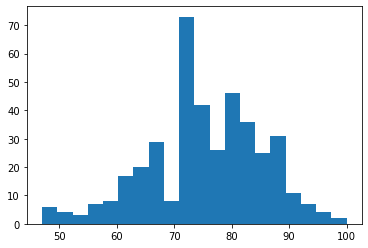

In [510]:
plt.hist(weather_df['Temp'], bins = 20);

In [511]:
weather_df.describe()

,Temp,Wind
count,405.000000,405.000000
mean,75.333333,3.244444
std,10.017559,0.711991
min,47.000000,1.000000
25%,70.000000,3.000000
50%,75.000000,3.000000
75%,82.000000,3.000000
max,100.000000,5.000000


In [512]:
len(weather_df['Park'].unique())

31

In [513]:
len(weather_df['Date'].unique())

30

In [514]:
main_df = main_df.merge(weather_df, on = ['Date', 'Park'], how = 'left')

In [515]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5537 entries, 0 to 5536
Data columns (total 125 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5537 non-null   datetime64[ns]
 1   Name            5537 non-null   object        
 2   Team            5537 non-null   object        
 3   HR              5537 non-null   int64         
 4   PA              5537 non-null   float64       
 5   HR_L30          5537 non-null   float64       
 6   H               5537 non-null   float64       
 7   1B              5537 non-null   float64       
 8   2B              5537 non-null   float64       
 9   3B              5537 non-null   float64       
 10  RBI             5537 non-null   float64       
 11  BB              5537 non-null   float64       
 12  SB              5537 non-null   float64       
 13  HBP             5537 non-null   float64       
 14  R               5537 non-null   float64       
 15  Eve

In [516]:
main_df.dropna(inplace=True)
main_df.reset_index(drop=True, inplace = True)

In [517]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
SP_BB/9,0,0.0
SP_EV,0,0.0
SP_Hard%,0,0.0
SP_Med%,0,0.0
SP_Soft%,0,0.0
SP_FB%,0,0.0
SP_LD%,0,0.0
SP_GB%,0,0.0
SP_FIP,0,0.0


In [518]:
null_data = main_df[main_df.isnull().any(axis=1)]
null_data

,Date,Name,Team,HR,PA,HR_L30,H,1B,2B,3B,...,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%,Pk_Fct_Overall,Pk_Fct_HR,Temp,Wind


<a href='#contents'>Back to Table of Contents</a>

<a id='Fixing_Data_Types'></a>

# Fixing data types

In [519]:
main_df.select_dtypes(include = object).T

,0,1,2,3,4,5,6,7,8,9,...,5511,5512,5513,5514,5515,5516,5517,5518,5519,5520
Name,Jared Walsh,Andrew Benintendi,Salvador Perez,Willie Calhoun,Jeimer Candelario,Josh Rojas,Alec Bohm,Nico Hoerner,Niko Goodrum,Isiah Kiner-Falefa,...,Willi Castro,Kevin Newman,Ian Happ,Harrison Bader,Jahmai Jones,Yuli Gurriel,Brent Rooker,Abraham Toro,Cal Raleigh,Ryan Jeffers
Team,LAA,KCR,KCR,TEX,DET,ARI,PHI,CHC,DET,TEX,...,DET,PIT,CHC,STL,BAL,HOU,MIN,SEA,SEA,MIN
Barrel%,13.2%,6.3%,13.9%,5.3%,5.2%,6.7%,11.0%,3.8%,15.4%,4.3%,...,8.6%,3.8%,11.3%,2.7%,10.0%,4.8%,11.8%,9.4%,5.1%,17.6%
HardHit%,33.8%,37.5%,52.8%,42.1%,37.7%,44.4%,52.1%,46.2%,56.4%,37.6%,...,36.2%,32.9%,41.9%,26.0%,30.0%,41.3%,47.1%,39.6%,38.5%,44.1%
BB%,8.2%,10.6%,3.8%,6.1%,8.0%,12.3%,5.7%,17.9%,7.7%,3.3%,...,2.4%,5.6%,9.2%,7.1%,0.0%,9.6%,10.8%,8.9%,4.5%,4.8%
K%,19.4%,21.3%,26.7%,14.3%,23.9%,26.0%,25.5%,15.4%,41.0%,19.5%,...,25.0%,5.6%,33.9%,26.5%,38.9%,14.5%,29.0%,11.3%,34.8%,33.9%
LD%,25.0%,21.0%,26.4%,23.7%,28.6%,22.2%,23.3%,19.2%,25.6%,20.7%,...,20.7%,21.5%,24.6%,15.1%,10.0%,20.6%,21.6%,18.8%,17.9%,23.5%
GB%,36.8%,46.8%,37.5%,44.7%,35.1%,53.3%,46.6%,53.8%,25.6%,58.7%,...,41.4%,36.7%,41.0%,42.5%,40.0%,46.0%,47.1%,34.4%,30.8%,47.1%
FB%,38.2%,32.3%,36.1%,31.6%,36.4%,24.4%,30.1%,26.9%,48.7%,20.7%,...,37.9%,41.8%,34.4%,42.5%,50.0%,33.3%,31.4%,46.9%,51.3%,29.4%
IFFB%,23.1%,5.0%,11.5%,33.3%,3.6%,0.0%,9.1%,0.0%,0.0%,0.0%,...,18.2%,9.1%,9.5%,22.6%,40.0%,0.0%,6.3%,4.4%,15.0%,30.0%


In [520]:
main_df_obj = main_df.select_dtypes(include=['object', 'datetime64[ns]'])

In [521]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5521 non-null   datetime64[ns]
 1   Name         5521 non-null   object        
 2   Team         5521 non-null   object        
 3   Barrel%      5521 non-null   object        
 4   HardHit%     5521 non-null   object        
 5   BB%          5521 non-null   object        
 6   K%           5521 non-null   object        
 7   LD%          5521 non-null   object        
 8   GB%          5521 non-null   object        
 9   FB%          5521 non-null   object        
 10  IFFB%        5521 non-null   object        
 11  HR/FB        5521 non-null   object        
 12  O-Swing%     5521 non-null   object        
 13  Z-Swing%     5521 non-null   object        
 14  Swing%       5521 non-null   object        
 15  O-Contact%   5521 non-null   object        
 16  Z-Cont

# Separating non-number objects

We'll probably want these six columns to be the first ones in the dataframe.

In [522]:
non_num_obj = main_df_obj.iloc[:, [0, 1, 2, 27, 28, 29, 30, 31, 32]]

In [523]:
non_num_obj.head()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher
0,2021-05-01,Jared Walsh,LAA,L,R,LNEWSOME,SEA,SEA,Ljay Newsome
1,2021-05-01,Andrew Benintendi,KCR,L,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker
2,2021-05-01,Salvador Perez,KCR,R,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker
3,2021-05-01,Willie Calhoun,TEX,L,L,ERODRIGUE-L,BOS,TEX,Eduardo Rodriguez
4,2021-05-01,Jeimer Candelario,DET,S,R,JTAILLON,NYY,NYY,Jameson Taillon


In [524]:
main_df_obj = main_df_obj.drop(['Date', 'Name', 'Team', 'Bats', 'Opp_Hand', 'Opp_Pitcher', 'Opp_Team', 'Park', 'Pitcher'], 1)

In [525]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Barrel%      5521 non-null   object
 1   HardHit%     5521 non-null   object
 2   BB%          5521 non-null   object
 3   K%           5521 non-null   object
 4   LD%          5521 non-null   object
 5   GB%          5521 non-null   object
 6   FB%          5521 non-null   object
 7   IFFB%        5521 non-null   object
 8   HR/FB        5521 non-null   object
 9   O-Swing%     5521 non-null   object
 10  Z-Swing%     5521 non-null   object
 11  Swing%       5521 non-null   object
 12  O-Contact%   5521 non-null   object
 13  Z-Contact%   5521 non-null   object
 14  Contact%     5521 non-null   object
 15  Zone%        5521 non-null   object
 16  F-Strike%    5521 non-null   object
 17  SwStr%       5521 non-null   object
 18  Soft%        5521 non-null   object
 19  Med%         5521 non-null 

In [526]:
main_df_nums = main_df.select_dtypes(include=['int64', 'float'])

In [527]:
main_df_nums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 72 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HR              5521 non-null   int64  
 1   PA              5521 non-null   float64
 2   HR_L30          5521 non-null   float64
 3   H               5521 non-null   float64
 4   1B              5521 non-null   float64
 5   2B              5521 non-null   float64
 6   3B              5521 non-null   float64
 7   RBI             5521 non-null   float64
 8   BB              5521 non-null   float64
 9   SB              5521 non-null   float64
 10  HBP             5521 non-null   float64
 11  R               5521 non-null   float64
 12  Events          5521 non-null   float64
 13  EV              5521 non-null   float64
 14  maxEV           5521 non-null   float64
 15  LA              5521 non-null   float64
 16  Barrels         5521 non-null   float64
 17  HardHit         5521 non-null   f

In [528]:
main_df_nums.describe()

,HR,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,...,BP_SIERA,BP_EV,BP_LA,BP_Barrels,BP_maxEV,BP_HardHit,Pk_Fct_Overall,Pk_Fct_HR,Temp,Wind
count,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,...,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000
mean,0.141279,81.943307,2.957435,18.713095,11.725412,3.745517,0.284731,10.138924,7.377287,1.062308,...,3.991639,88.546948,12.609672,20.917769,113.600489,104.449194,99.839522,99.589748,75.517479,3.256294
std,0.378259,31.019481,2.440116,8.816112,6.167994,2.558711,0.559892,6.044228,4.700314,1.695399,...,0.403163,1.152545,2.566395,5.949039,2.200126,18.858070,3.869610,14.371418,9.851861,0.722609
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.990000,85.000000,3.100000,5.000000,109.000000,51.000000,93.000000,68.000000,47.000000,1.000000
25%,0.000000,62.000000,1.000000,12.000000,7.000000,2.000000,0.000000,6.000000,4.000000,0.000000,...,3.700000,87.800000,10.900000,17.000000,111.900000,91.000000,97.000000,89.000000,70.000000,3.000000
50%,0.000000,89.000000,2.000000,19.000000,12.000000,3.000000,0.000000,10.000000,7.000000,0.000000,...,3.990000,88.700000,12.700000,20.000000,113.500000,103.000000,100.000000,98.000000,75.000000,3.000000
75%,0.000000,107.000000,4.000000,25.000000,16.000000,5.000000,0.000000,14.000000,10.000000,1.000000,...,4.270000,89.300000,14.300000,25.000000,115.100000,117.000000,102.000000,107.000000,82.000000,4.000000
max,3.000000,144.000000,17.000000,45.000000,34.000000,16.000000,4.000000,40.000000,33.000000,20.000000,...,5.120000,92.600000,20.200000,39.000000,120.200000,158.000000,110.000000,148.000000,100.000000,5.000000


In [529]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,13.2%,33.8%,8.2%,19.4%,25.0%,36.8%,38.2%,23.1%,23.1%,34.8%,...,36.4%,49.0%,5.6%,16.0%,35.0%,13.2%,54.5%,32.3%,5.0%,36.0%
1,6.3%,37.5%,10.6%,21.3%,21.0%,46.8%,32.3%,5.0%,15.0%,29.6%,...,37.9%,42.7%,16.2%,23.6%,33.6%,19.0%,50.2%,30.8%,11.3%,48.4%
2,13.9%,52.8%,3.8%,26.7%,26.4%,37.5%,36.1%,11.5%,23.1%,50.2%,...,37.9%,42.7%,16.2%,23.6%,33.6%,19.0%,50.2%,30.8%,11.3%,48.4%
3,5.3%,42.1%,6.1%,14.3%,23.7%,44.7%,31.6%,33.3%,16.7%,30.5%,...,36.1%,46.5%,8.8%,20.3%,33.2%,20.0%,52.2%,27.8%,6.1%,42.4%
4,5.2%,37.7%,8.0%,23.9%,28.6%,35.1%,36.4%,3.6%,7.1%,36.1%,...,38.0%,42.0%,8.3%,18.5%,39.5%,22.4%,53.7%,24.0%,5.3%,29.6%


# Removing percentage sign and changing strings to numeric type

In [530]:
main_df_obj_cols = list(main_df_obj.columns)

In [531]:
main_df_obj[main_df_obj_cols] = main_df_obj[main_df_obj_cols].replace({'\%':''}, regex = True)

In [532]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,13.2,33.8,8.2,19.4,25.0,36.8,38.2,23.1,23.1,34.8,...,36.4,49.0,5.6,16.0,35.0,13.2,54.5,32.3,5.0,36.0
1,6.3,37.5,10.6,21.3,21.0,46.8,32.3,5.0,15.0,29.6,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
2,13.9,52.8,3.8,26.7,26.4,37.5,36.1,11.5,23.1,50.2,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
3,5.3,42.1,6.1,14.3,23.7,44.7,31.6,33.3,16.7,30.5,...,36.1,46.5,8.8,20.3,33.2,20.0,52.2,27.8,6.1,42.4
4,5.2,37.7,8.0,23.9,28.6,35.1,36.4,3.6,7.1,36.1,...,38.0,42.0,8.3,18.5,39.5,22.4,53.7,24.0,5.3,29.6


In [533]:
def change_to_num(cols, df):
    for col in cols:
        df[col] = pd.to_numeric(df[col])  

In [534]:
change_to_num(main_df_obj_cols, main_df_obj)

In [535]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,13.2,33.8,8.2,19.4,25.0,36.8,38.2,23.1,23.1,34.8,...,36.4,49.0,5.6,16.0,35.0,13.2,54.5,32.3,5.0,36.0
1,6.3,37.5,10.6,21.3,21.0,46.8,32.3,5.0,15.0,29.6,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
2,13.9,52.8,3.8,26.7,26.4,37.5,36.1,11.5,23.1,50.2,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
3,5.3,42.1,6.1,14.3,23.7,44.7,31.6,33.3,16.7,30.5,...,36.1,46.5,8.8,20.3,33.2,20.0,52.2,27.8,6.1,42.4
4,5.2,37.7,8.0,23.9,28.6,35.1,36.4,3.6,7.1,36.1,...,38.0,42.0,8.3,18.5,39.5,22.4,53.7,24.0,5.3,29.6


In [536]:
main_df = pd.concat([non_num_obj, main_df_nums, main_df_obj], axis = 1)

In [537]:
main_df.head()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,HR,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,2021-05-01,Jared Walsh,LAA,L,R,LNEWSOME,SEA,SEA,Ljay Newsome,2,...,36.4,49.0,5.6,16.0,35.0,13.2,54.5,32.3,5.0,36.0
1,2021-05-01,Andrew Benintendi,KCR,L,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,2,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
2,2021-05-01,Salvador Perez,KCR,R,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,1,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
3,2021-05-01,Willie Calhoun,TEX,L,L,ERODRIGUE-L,BOS,TEX,Eduardo Rodriguez,1,...,36.1,46.5,8.8,20.3,33.2,20.0,52.2,27.8,6.1,42.4
4,2021-05-01,Jeimer Candelario,DET,S,R,JTAILLON,NYY,NYY,Jameson Taillon,1,...,38.0,42.0,8.3,18.5,39.5,22.4,53.7,24.0,5.3,29.6


In [538]:
main_df.tail()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,HR,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
5516,2021-08-29,Yuli Gurriel,HOU,R,L,THEARN-L,TEX,TEX,Taylor Hearn,0,...,27.4,38.0,8.7,19.0,43.0,15.0,52.9,32.1,6.4,34.6
5517,2021-08-29,Brent Rooker,MIN,R,L,AASHBY-L,MIL,MIN,Aaron Ashby,0,...,22.7,40.0,12.8,21.1,38.9,16.8,51.6,31.6,7.0,34.4
5518,2021-08-29,Abraham Toro,SEA,S,R,BSINGER,KCR,SEA,Brady Singer,0,...,39.2,38.4,6.5,23.1,38.4,13.8,49.3,36.9,8.1,41.0
5519,2021-08-29,Cal Raleigh,SEA,S,R,BSINGER,KCR,SEA,Brady Singer,0,...,39.2,38.4,6.5,23.1,38.4,13.8,49.3,36.9,8.1,41.0
5520,2021-08-29,Ryan Jeffers,MIN,R,L,AASHBY-L,MIL,MIN,Aaron Ashby,0,...,22.7,40.0,12.8,21.1,38.9,16.8,51.6,31.6,7.0,34.4


In [539]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [540]:
null_data

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,HR,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%


In [541]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
Temp,0,0.0
Swing%,0,0.0
Z-Swing%,0,0.0
O-Swing%,0,0.0
HR/FB,0,0.0
IFFB%,0,0.0
FB%,0,0.0
GB%,0,0.0
LD%,0,0.0


In [542]:
print(all(main_df))

True


In [543]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 125 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5521 non-null   datetime64[ns]
 1   Name            5521 non-null   object        
 2   Team            5521 non-null   object        
 3   Bats            5521 non-null   object        
 4   Opp_Hand        5521 non-null   object        
 5   Opp_Pitcher     5521 non-null   object        
 6   Opp_Team        5521 non-null   object        
 7   Park            5521 non-null   object        
 8   Pitcher         5521 non-null   object        
 9   HR              5521 non-null   int64         
 10  PA              5521 non-null   float64       
 11  HR_L30          5521 non-null   float64       
 12  H               5521 non-null   float64       
 13  1B              5521 non-null   float64       
 14  2B              5521 non-null   float64       
 15  3B 

In [544]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
HR,5521.0,0.141279,0.378259,0.000000,0.000000,0.000000,0.000000,3.00000
PA,5521.0,81.943307,31.019481,1.000000,62.000000,89.000000,107.000000,144.00000
HR_L30,5521.0,2.957435,2.440116,0.000000,1.000000,2.000000,4.000000,17.00000
H,5521.0,18.713095,8.816112,0.000000,12.000000,19.000000,25.000000,45.00000
1B,5521.0,11.725412,6.167994,0.000000,7.000000,12.000000,16.000000,34.00000
2B,5521.0,3.745517,2.558711,0.000000,2.000000,3.000000,5.000000,16.00000
3B,5521.0,0.284731,0.559892,0.000000,0.000000,0.000000,0.000000,4.00000
RBI,5521.0,10.138924,6.044228,0.000000,6.000000,10.000000,14.000000,40.00000
BB,5521.0,7.377287,4.700314,0.000000,4.000000,7.000000,10.000000,33.00000
SB,5521.0,1.062308,1.695399,0.000000,0.000000,0.000000,1.000000,20.00000


In [545]:
main_df.iloc[2495, :]

Date              2021-06-22 00:00:00
Name                        Skye Bolt
Team                              OAK
Bats                                S
Opp_Hand                            L
Opp_Pitcher                  THEARN-L
Opp_Team                          TEX
Park                              TEX
Pitcher                  Taylor Hearn
HR                                  0
PA                                 14
HR_L30                              1
H                                   1
1B                                  0
2B                                  0
3B                                  0
RBI                                 1
BB                                  0
SB                                  0
HBP                                 0
R                                   1
Events                             11
EV                               84.2
maxEV                           103.8
LA                                 12
Barrels                             1
HardHit     

In [546]:
#Spotcheck
main_df.sample(1).T

,3288
Date,2021-07-08 00:00:00
Name,Zach McKinstry
Team,LAD
Bats,L
Opp_Hand,R
Opp_Pitcher,SALCANTAR
Opp_Team,MIA
Park,MIA
Pitcher,Sandy Alcantara
HR,0


In [547]:
#Checking value counts for each of our 30 dates. Only 67 on Aug. 9 but that was a Monday and schedules can be light on Mondays.
main_df['Date'].value_counts()

2021-07-24    232
2021-08-21    230
2021-06-22    226
2021-06-06    224
2021-06-18    216
2021-05-25    216
2021-05-05    213
2021-05-01    210
2021-08-17    207
2021-07-04    203
2021-07-28    199
2021-07-20    197
2021-07-16    195
2021-05-21    195
2021-08-29    195
2021-08-13    190
2021-06-14    189
2021-05-09    183
2021-08-05    177
2021-06-30    177
2021-05-13    176
2021-06-26    176
2021-08-01    175
2021-08-25    164
2021-05-29    147
2021-06-02    142
2021-06-10    139
2021-05-17    132
2021-07-08    129
2021-08-09     67
Name: Date, dtype: int64

In [548]:
#Checking Name column. No name should appear more than 30 times.
main_df['Name'].value_counts().max()

27

In [549]:
#Making sure we have three values for Bats column.
main_df['Bats'].value_counts()

R    3188
L    1671
S     662
Name: Bats, dtype: int64

In [550]:
#Checking Opp_Hand column. 
#Two values and it sounds about right that there are more than twice as many righties as lefties.
main_df['Opp_Hand'].value_counts()

R    3741
L    1780
Name: Opp_Hand, dtype: int64

In [551]:
#Checking Park column
#We're looking at value counts and unique here. 
#TOR and BUF are the two lowest value counts, as expected, 
#because we dropped a lot of TOR home games and the Blue Jays only played in BUF for part of the year. 
#We also see that there are 31 different values, 30 teams plus we added BUF.
main_df['Park'].value_counts()

SEA    244
NYY    231
MIN    230
WSN    220
KCR    208
CIN    204
OAK    201
COL    198
HOU    197
BOS    196
CHW    196
STL    195
TEX    194
SDP    193
ARI    191
MIA    189
LAA    181
ATL    178
TBR    171
DET    171
MIL    170
PIT    164
NYM    160
PHI    160
SFG    152
CLE    147
CHC    146
BAL    142
LAD    130
BUF    101
TOR     61
Name: Park, dtype: int64

In [552]:
len(main_df['Park'].unique())

31

<a href='#contents'>Back to Table of Contents</a>

<a id='Categorical'></a>

# Creating categorical variables for handedness matchups
Four possible values:<br>
Righty vs righty (RvR)<br>
Switch-and-lefty vs. righty (SLvR)<br>
Lefty vs lefty (LvL)<br>
Switch-and-righty vs. lefty (SRvL)<br>
We assume switch-hitters will opt to bat against their opposite hand

In [553]:
conds = [(main_df['Bats'] == 'R') & (main_df['Opp_Hand'] == 'R'), \
         (main_df['Bats'] != 'R') & (main_df['Opp_Hand'] == 'R'),\
        (main_df['Bats'] == 'L') & (main_df['Opp_Hand'] == 'L'),\
        (main_df['Bats'] != 'L') & (main_df['Opp_Hand'] == 'L')]
choices = ['RvR', 'SLvR', 'LvL', 'SRvL']

In [554]:
main_df['Hnd_Mtch'] = np.select(conds, choices)

## Dummy variables for our categorical variables

In [555]:
main_df = pd.get_dummies(main_df, columns = ['Hnd_Mtch'], drop_first = False, prefix = 'HM_')

In [556]:
main_df.head()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,HR,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
0,2021-05-01,Jared Walsh,LAA,L,R,LNEWSOME,SEA,SEA,Ljay Newsome,2,...,35.0,13.2,54.5,32.3,5.0,36.0,0,0,1,0
1,2021-05-01,Andrew Benintendi,KCR,L,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,2,...,33.6,19.0,50.2,30.8,11.3,48.4,0,0,1,0
2,2021-05-01,Salvador Perez,KCR,R,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,1,...,33.6,19.0,50.2,30.8,11.3,48.4,0,1,0,0
3,2021-05-01,Willie Calhoun,TEX,L,L,ERODRIGUE-L,BOS,TEX,Eduardo Rodriguez,1,...,33.2,20.0,52.2,27.8,6.1,42.4,1,0,0,0
4,2021-05-01,Jeimer Candelario,DET,S,R,JTAILLON,NYY,NYY,Jameson Taillon,1,...,39.5,22.4,53.7,24.0,5.3,29.6,0,0,1,0


In [557]:
#Dropping columns we don't need now that we have handedness matchups, park factors and pitcher information
main_df.drop(columns = ['Team', 'Bats', 'Opp_Hand', 'Opp_Pitcher', 'Opp_Team', 'Park', 'Pitcher'], inplace = True)

In [558]:
main_df.shape

(5521, 122)

<a id='Histogram'></a>

# Histogram time
We need a new set of histograms since we added so many features. Some scrolling is required because there are 122 features.

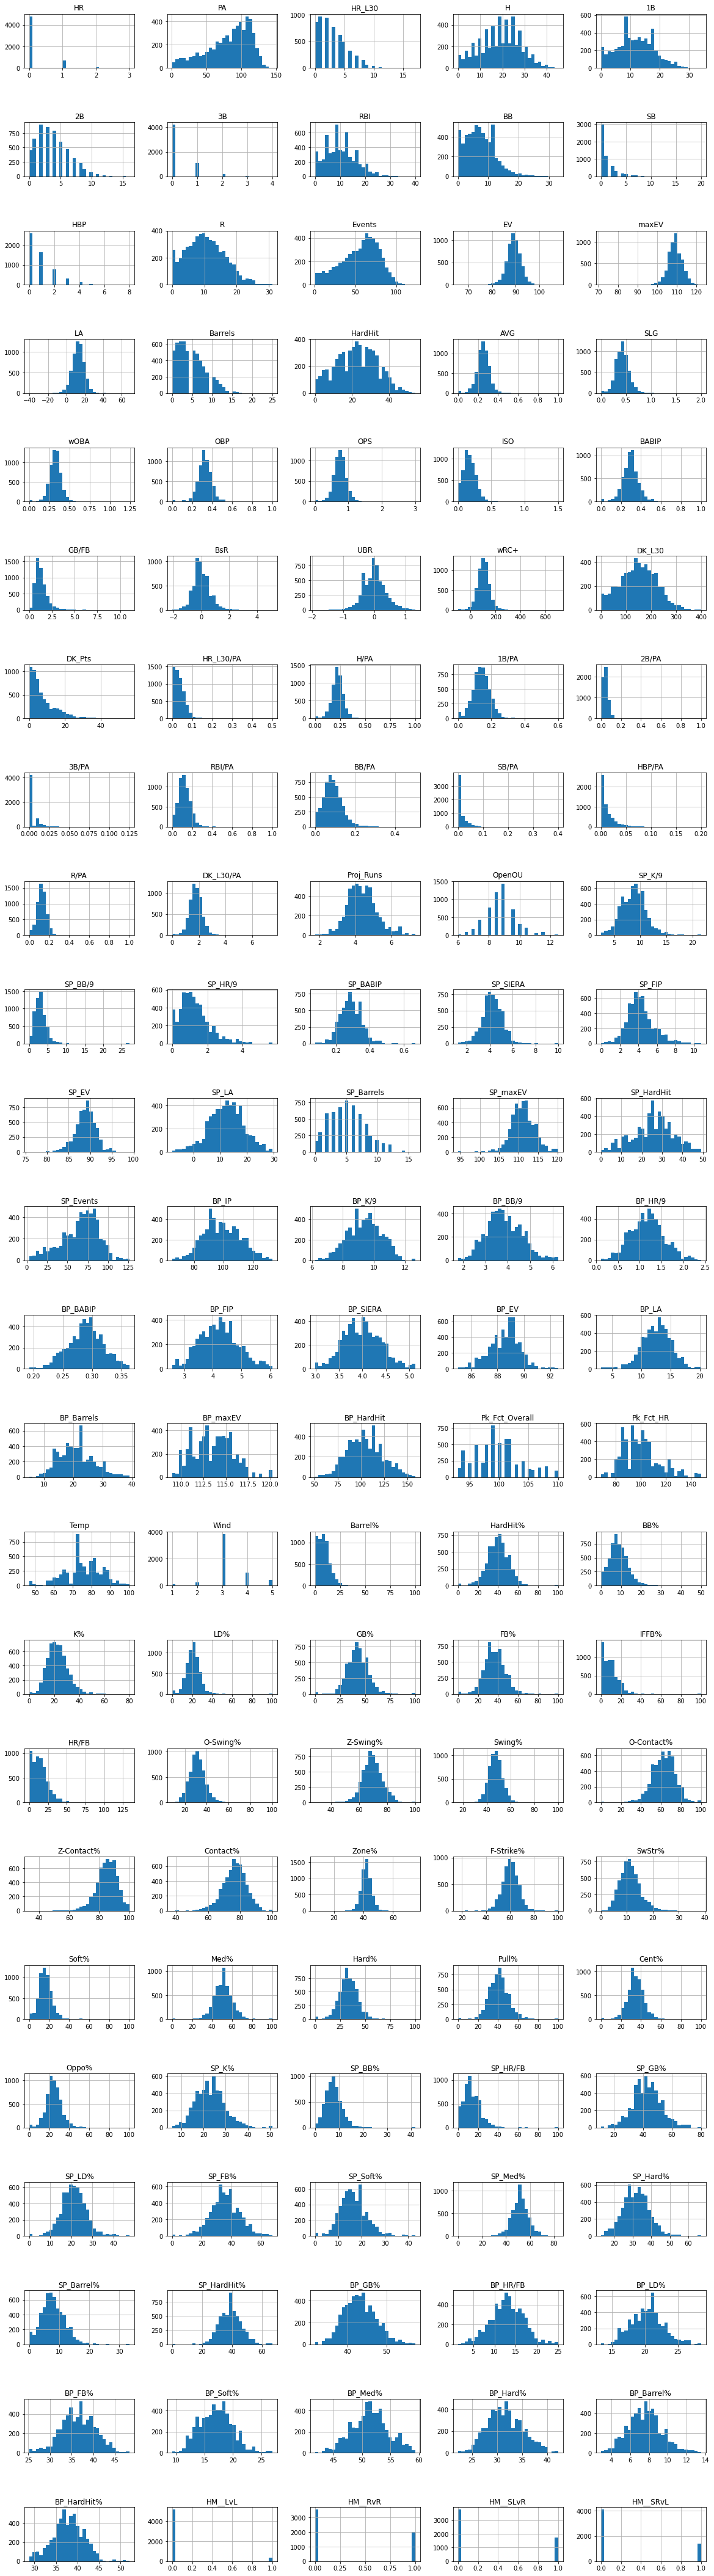

In [559]:
main_df.hist(layout=(25, 5), figsize=(20,80), bins = 30)
plt.subplots_adjust(hspace=1)
plt.show()

# A closer look at our target variable histogram

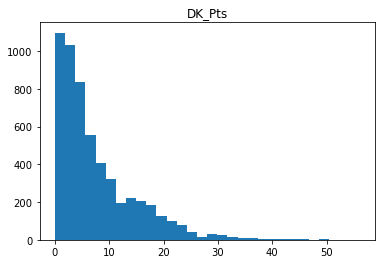

In [560]:
plt.hist(main_df['DK_Pts'], bins = 30)
plt.title('DK_Pts')
plt.show()

In [561]:
main_df['DK_Pts'].max()

56

In [562]:
#Making 'HR' our target variable for classification
main_df['HR'] = main_df['HR'] >= 1

In [563]:
main_df['HR'].value_counts()

False    4797
True      724
Name: HR, dtype: int64

In [564]:
main_df.shape

(5521, 122)

In [565]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 122 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5521 non-null   datetime64[ns]
 1   Name            5521 non-null   object        
 2   HR              5521 non-null   bool          
 3   PA              5521 non-null   float64       
 4   HR_L30          5521 non-null   float64       
 5   H               5521 non-null   float64       
 6   1B              5521 non-null   float64       
 7   2B              5521 non-null   float64       
 8   3B              5521 non-null   float64       
 9   RBI             5521 non-null   float64       
 10  BB              5521 non-null   float64       
 11  SB              5521 non-null   float64       
 12  HBP             5521 non-null   float64       
 13  R               5521 non-null   float64       
 14  Events          5521 non-null   float64       
 15  EV 

In [566]:
main_df.shape

(5521, 122)

<a id='#contents'>Back to Table of Contents<a>

<a id='Correlations'></a>

# Checking correlations
Even though this didn't turn out to be a regression task, we'll still present the regression models so it's clear why regression didn't work.<br>

The first sign that regression wasn't the answer was the fact that we never could get correlations much stronger than .1. However, of the top 11 correlations below (not counting the target), eight are new features that we derived after the first round of modeling. DK_L30, DraftKings points over the last 30 days, now becomes our strongest correlation.<br>

In [567]:
main_df_corr = main_df.corr()

In [568]:
main_df_corr_sorted = main_df_corr.unstack().sort_values(ascending = False)

In [569]:
DK_corr_list = main_df_corr_sorted.loc['DK_Pts']

In [570]:
DK_corr_list

DK_Pts            1.000000
HR                0.713883
DK_L30            0.113534
HardHit           0.106452
Barrels           0.103426
RBI               0.098562
H                 0.091735
PA                0.090010
R                 0.088499
HR_L30            0.088220
BB                0.087143
DK_L30/PA         0.085892
SB                0.085415
maxEV             0.084418
EV                0.084361
Proj_Runs         0.083220
HardHit%          0.082481
wOBA              0.080831
OPS               0.079657
wRC+              0.078526
Events            0.076795
SLG               0.074151
OBP               0.073630
Hard%             0.073590
2B                0.071636
Temp              0.066864
1B                0.063175
ISO               0.063072
AVG               0.062234
Barrel%           0.059494
RBI/PA            0.058557
Pk_Fct_Overall    0.056810
H/PA              0.056112
OpenOU            0.055847
SB/PA             0.053334
HR_L30/PA         0.050643
BP_SIERA          0.049895
H

In [571]:
features = DK_corr_list[1:]
features

HR                0.713883
DK_L30            0.113534
HardHit           0.106452
Barrels           0.103426
RBI               0.098562
H                 0.091735
PA                0.090010
R                 0.088499
HR_L30            0.088220
BB                0.087143
DK_L30/PA         0.085892
SB                0.085415
maxEV             0.084418
EV                0.084361
Proj_Runs         0.083220
HardHit%          0.082481
wOBA              0.080831
OPS               0.079657
wRC+              0.078526
Events            0.076795
SLG               0.074151
OBP               0.073630
Hard%             0.073590
2B                0.071636
Temp              0.066864
1B                0.063175
ISO               0.063072
AVG               0.062234
Barrel%           0.059494
RBI/PA            0.058557
Pk_Fct_Overall    0.056810
H/PA              0.056112
OpenOU            0.055847
SB/PA             0.053334
HR_L30/PA         0.050643
BP_SIERA          0.049895
HR/FB             0.047746
P

# Slight improvement
Here we see that the mean of our correlations without the target is 0.026328. Before adding the new features, it was 0.019293

In [572]:
features.describe()

count    119.000000
mean       0.032106
std        0.074503
min       -0.049860
25%       -0.004171
50%        0.020706
75%        0.057684
max        0.713883
dtype: float64

In [573]:
features = features.index.to_list()

In [574]:
features

['HR',
 'DK_L30',
 'HardHit',
 'Barrels',
 'RBI',
 'H',
 'PA',
 'R',
 'HR_L30',
 'BB',
 'DK_L30/PA',
 'SB',
 'maxEV',
 'EV',
 'Proj_Runs',
 'HardHit%',
 'wOBA',
 'OPS',
 'wRC+',
 'Events',
 'SLG',
 'OBP',
 'Hard%',
 '2B',
 'Temp',
 '1B',
 'ISO',
 'AVG',
 'Barrel%',
 'RBI/PA',
 'Pk_Fct_Overall',
 'H/PA',
 'OpenOU',
 'SB/PA',
 'HR_L30/PA',
 'BP_SIERA',
 'HR/FB',
 'Pk_Fct_HR',
 'BsR',
 'BP_Hard%',
 'BB%',
 'BB/PA',
 'BABIP',
 'BP_EV',
 'BP_FIP',
 'R/PA',
 '3B',
 'BP_HardHit%',
 'BP_HardHit',
 'SP_EV',
 'Z-Swing%',
 '2B/PA',
 'SP_BABIP',
 'BP_BB/9',
 'LA',
 'FB%',
 'SP_SIERA',
 'SP_Hard%',
 'BP_HR/9',
 'HM__SLvR',
 'SP_BB%',
 'SP_BB/9',
 'BP_Barrels',
 'SP_HardHit%',
 'BP_HR/FB',
 '1B/PA',
 '3B/PA',
 'SP_LD%',
 'UBR',
 'BP_LD%',
 'BP_Barrel%',
 'HM__RvR',
 'Oppo%',
 'SP_LA',
 'SP_FIP',
 'Wind',
 'BP_IP',
 'SP_Med%',
 'Contact%',
 'LD%',
 'Pull%',
 'BP_GB%',
 'Z-Contact%',
 'HBP',
 'O-Contact%',
 'SP_GB%',
 'SP_K/9',
 'SP_HR/9',
 'SwStr%',
 'BP_BABIP',
 'BP_Med%',
 'SP_FB%',
 'BP_FB%',
 'F-

<a id='Train_Test'></a>

# Train-test split
This will be the train-test split for our classification. In the final edition of this notebook, we run this and then skip the regression cells.

In [575]:
y = main_df['HR']

In [576]:
main_df.shape

(5521, 122)

In [577]:
main_df.drop(columns = ['HR', 'DK_Pts'], inplace = True)
main_df.shape

(5521, 120)

In [578]:
main_df.head()

,Date,Name,PA,HR_L30,H,1B,2B,3B,RBI,BB,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
0,2021-05-01,Jared Walsh,98.0,6.0,31.0,20.0,4.0,1.0,21.0,8.0,...,35.0,13.2,54.5,32.3,5.0,36.0,0,0,1,0
1,2021-05-01,Andrew Benintendi,94.0,3.0,21.0,14.0,4.0,0.0,10.0,10.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,0,1,0
2,2021-05-01,Salvador Perez,105.0,6.0,28.0,15.0,7.0,0.0,16.0,4.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,1,0,0
3,2021-05-01,Willie Calhoun,49.0,2.0,15.0,12.0,1.0,0.0,5.0,3.0,...,33.2,20.0,52.2,27.8,6.1,42.4,1,0,0,0
4,2021-05-01,Jeimer Candelario,113.0,2.0,29.0,22.0,5.0,0.0,8.0,9.0,...,39.5,22.4,53.7,24.0,5.3,29.6,0,0,1,0


In [581]:
main_df = main_df.set_index('Name')

In [582]:
main_df.head()

,Date,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
Name,,,,,,,,,,,,,,,,,,,,,
Jared Walsh,2021-05-01,98.0,6.0,31.0,20.0,4.0,1.0,21.0,8.0,0.0,...,35.0,13.2,54.5,32.3,5.0,36.0,0,0,1,0
Andrew Benintendi,2021-05-01,94.0,3.0,21.0,14.0,4.0,0.0,10.0,10.0,4.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,0,1,0
Salvador Perez,2021-05-01,105.0,6.0,28.0,15.0,7.0,0.0,16.0,4.0,0.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,1,0,0
Willie Calhoun,2021-05-01,49.0,2.0,15.0,12.0,1.0,0.0,5.0,3.0,0.0,...,33.2,20.0,52.2,27.8,6.1,42.4,1,0,0,0
Jeimer Candelario,2021-05-01,113.0,2.0,29.0,22.0,5.0,0.0,8.0,9.0,0.0,...,39.5,22.4,53.7,24.0,5.3,29.6,0,0,1,0


In [583]:
main_df.drop(columns = ['Date'], inplace = True)

In [584]:
main_df.shape

(5521, 118)

In [585]:
main_df.head()

,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,HBP,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
Name,,,,,,,,,,,,,,,,,,,,,
Jared Walsh,98.0,6.0,31.0,20.0,4.0,1.0,21.0,8.0,0.0,3.0,...,35.0,13.2,54.5,32.3,5.0,36.0,0,0,1,0
Andrew Benintendi,94.0,3.0,21.0,14.0,4.0,0.0,10.0,10.0,4.0,0.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,0,1,0
Salvador Perez,105.0,6.0,28.0,15.0,7.0,0.0,16.0,4.0,0.0,1.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,1,0,0
Willie Calhoun,49.0,2.0,15.0,12.0,1.0,0.0,5.0,3.0,0.0,1.0,...,33.2,20.0,52.2,27.8,6.1,42.4,1,0,0,0
Jeimer Candelario,113.0,2.0,29.0,22.0,5.0,0.0,8.0,9.0,0.0,0.0,...,39.5,22.4,53.7,24.0,5.3,29.6,0,0,1,0


In [586]:
features = list(main_df.columns)

In [587]:
features

['PA',
 'HR_L30',
 'H',
 '1B',
 '2B',
 '3B',
 'RBI',
 'BB',
 'SB',
 'HBP',
 'R',
 'Events',
 'EV',
 'maxEV',
 'LA',
 'Barrels',
 'HardHit',
 'AVG',
 'SLG',
 'wOBA',
 'OBP',
 'OPS',
 'ISO',
 'BABIP',
 'GB/FB',
 'BsR',
 'UBR',
 'wRC+',
 'DK_L30',
 'HR_L30/PA',
 'H/PA',
 '1B/PA',
 '2B/PA',
 '3B/PA',
 'RBI/PA',
 'BB/PA',
 'SB/PA',
 'HBP/PA',
 'R/PA',
 'DK_L30/PA',
 'Proj_Runs',
 'OpenOU',
 'SP_K/9',
 'SP_BB/9',
 'SP_HR/9',
 'SP_BABIP',
 'SP_SIERA',
 'SP_FIP',
 'SP_EV',
 'SP_LA',
 'SP_Barrels',
 'SP_maxEV',
 'SP_HardHit',
 'SP_Events',
 'BP_IP',
 'BP_K/9',
 'BP_BB/9',
 'BP_HR/9',
 'BP_BABIP',
 'BP_FIP',
 'BP_SIERA',
 'BP_EV',
 'BP_LA',
 'BP_Barrels',
 'BP_maxEV',
 'BP_HardHit',
 'Pk_Fct_Overall',
 'Pk_Fct_HR',
 'Temp',
 'Wind',
 'Barrel%',
 'HardHit%',
 'BB%',
 'K%',
 'LD%',
 'GB%',
 'FB%',
 'IFFB%',
 'HR/FB',
 'O-Swing%',
 'Z-Swing%',
 'Swing%',
 'O-Contact%',
 'Z-Contact%',
 'Contact%',
 'Zone%',
 'F-Strike%',
 'SwStr%',
 'Soft%',
 'Med%',
 'Hard%',
 'Pull%',
 'Cent%',
 'Oppo%',
 'SP_K%',

In [588]:
X = main_df[features]

In [589]:
X.head()

,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,HBP,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
Name,,,,,,,,,,,,,,,,,,,,,
Jared Walsh,98.0,6.0,31.0,20.0,4.0,1.0,21.0,8.0,0.0,3.0,...,35.0,13.2,54.5,32.3,5.0,36.0,0,0,1,0
Andrew Benintendi,94.0,3.0,21.0,14.0,4.0,0.0,10.0,10.0,4.0,0.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,0,1,0
Salvador Perez,105.0,6.0,28.0,15.0,7.0,0.0,16.0,4.0,0.0,1.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,1,0,0
Willie Calhoun,49.0,2.0,15.0,12.0,1.0,0.0,5.0,3.0,0.0,1.0,...,33.2,20.0,52.2,27.8,6.1,42.4,1,0,0,0
Jeimer Candelario,113.0,2.0,29.0,22.0,5.0,0.0,8.0,9.0,0.0,0.0,...,39.5,22.4,53.7,24.0,5.3,29.6,0,0,1,0


In [590]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [591]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [592]:
X_train = scaler.fit_transform(X_train)

In [593]:
X_test = scaler.transform(X_test)

In [594]:
X_scaled_df = pd.DataFrame(X_train, columns = features)

In [595]:
X_scaled_df.head()

,PA,HR_L30,H,1B,2B,3B,RBI,BB,SB,HBP,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
0,0.617455,0.424304,0.947491,0.866613,0.881576,-0.499102,1.464023,0.323578,-0.630542,-0.783371,...,0.909730,1.473357,-0.554427,-0.676752,0.398541,-1.103930,-0.276266,-0.747037,1.482793,-0.590102
1,0.552302,1.243649,0.604808,0.374414,0.101006,-0.499102,0.801787,-0.099824,-0.630542,-0.783371,...,-2.631386,0.507609,1.672797,-1.943652,-1.760596,-0.198157,-0.276266,-0.747037,1.482793,-0.590102
2,0.161389,-0.395041,-0.537466,-0.281851,-1.069851,1.271816,-1.019362,0.958680,-0.630542,0.037607,...,-0.019499,0.818028,1.672797,-2.140726,-0.597984,-1.405854,-0.276266,-0.747037,1.482793,-0.590102
3,-1.109081,-0.804714,-1.108604,-0.938116,-0.679565,-0.499102,-1.019362,-0.523225,-0.630542,-0.783371,...,0.156301,-0.182211,-0.868121,0.927990,2.446953,1.887864,-0.276266,-0.747037,1.482793,-0.590102
4,1.008369,0.424304,1.175946,1.030679,0.881576,1.271816,0.470669,0.323578,1.133698,0.037607,...,0.106073,0.921501,0.449392,-1.155359,-1.096246,0.268453,-0.276266,-0.747037,-0.674403,1.694622


In [596]:
X_scaled_df.mean()

PA                1.471103e-16
HR_L30           -4.125984e-17
H                -1.693492e-16
1B               -1.284629e-16
2B               -2.028513e-17
3B                2.142868e-16
RBI               1.202742e-16
BB                7.344022e-17
SB               -3.423475e-16
HBP              -1.348415e-16
R                -1.149299e-17
Events           -1.469954e-16
EV               -1.222869e-15
maxEV            -4.220227e-16
LA               -1.950935e-16
Barrels           9.539183e-18
HardHit          -4.597197e-19
AVG               1.074595e-16
SLG               4.604955e-16
wOBA              3.241024e-17
OBP              -3.007716e-16
OPS               9.280591e-18
ISO              -2.748549e-16
BABIP            -1.748946e-16
GB/FB            -2.190564e-16
BsR               2.482486e-17
UBR               2.643388e-17
wRC+             -7.076810e-17
DK_L30            5.252297e-17
HR_L30/PA         1.232623e-16
H/PA              1.508168e-16
1B/PA             8.280701e-17
2B/PA   

In [597]:
X_scaled_df.std()

PA                1.000129
HR_L30            1.000129
H                 1.000129
1B                1.000129
2B                1.000129
3B                1.000129
RBI               1.000129
BB                1.000129
SB                1.000129
HBP               1.000129
R                 1.000129
Events            1.000129
EV                1.000129
maxEV             1.000129
LA                1.000129
Barrels           1.000129
HardHit           1.000129
AVG               1.000129
SLG               1.000129
wOBA              1.000129
OBP               1.000129
OPS               1.000129
ISO               1.000129
BABIP             1.000129
GB/FB             1.000129
BsR               1.000129
UBR               1.000129
wRC+              1.000129
DK_L30            1.000129
HR_L30/PA         1.000129
H/PA              1.000129
1B/PA             1.000129
2B/PA             1.000129
3B/PA             1.000129
RBI/PA            1.000129
BB/PA             1.000129
SB/PA             1.000129
H

In [598]:
main_df.shape

(5521, 118)

<a id='Models'></a>

# Models
We'll start with basic, out-of-the-box Linear Regression.

In [796]:
from sklearn.linear_model import LinearRegression

In [797]:
from sklearn.metrics import mean_absolute_error

In [798]:
Baseline_reg = LinearRegression()
Baseline_reg.fit(X_train, y_train)
y_pred = Baseline_reg.predict(X_test)

print(f"Baseline_reg R-squared: {Baseline_reg.score(X_test, y_test)}")
print(f"Baseline_reg MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Baseline_reg RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Baseline_reg MSE: {mean_squared_error(y_test, y_pred)}")

Baseline_reg R-squared: 0.0011366877415929233
Baseline_reg MAE: 5.68589808866391
Baseline_reg RMSE: 7.5356786929075525
Baseline_reg MSE: 56.78645336274088


In [799]:
Baseline_reg.score(X_train, y_train)

0.06296989455787483

# 14 is the magic number
On DraftKings, a player gets 14 points if he hits a solo home run (10 for the home run itself, 2 for the RBI and 2 for the run he scores). So if a player scores 14, that might not necessarily be enough to help you win a big tournament, but there's a very good chance you can win a lot of cash games if your hitters average about 14 points and you get a satisfactory performance from your pitchers.<br>

Unfortunately, our Linear Regressor predicts only two players to score 14 or more points. We see below that there are at least 100 actual values higher than that. We'll print a list of the top 100 predicted values and the top 100 test values (actual DK points are integers).

In [800]:
np.sum(y_pred >= 14)

2

In [801]:
print(np.sort(y_pred)[-100:])

[10.17873691 10.20069426 10.20609282 10.21522279 10.23513743 10.23754244
 10.26025065 10.26430446 10.31160148 10.31544852 10.32664214 10.33877817
 10.37643901 10.40580977 10.41789498 10.4266285  10.43853643 10.46690932
 10.46859025 10.47352096 10.47715642 10.49036274 10.51763718 10.52225024
 10.54756952 10.55634228 10.55675431 10.56454898 10.61806276 10.62855564
 10.64280442 10.65103724 10.65829004 10.68856801 10.70113759 10.72633185
 10.72874385 10.73657944 10.74240958 10.76784947 10.7959022  10.7994917
 10.8124028  10.83192605 10.85865351 10.87379227 10.8893373  10.89074776
 10.89404262 10.91739586 10.9405723  10.95160949 10.99391401 11.0417583
 11.07464958 11.08587906 11.08816341 11.11987902 11.13472324 11.13846242
 11.18813137 11.2050746  11.2317657  11.2371144  11.24878983 11.27808604
 11.28016255 11.32656806 11.34160245 11.36652913 11.3673218  11.37850373
 11.41310643 11.42299826 11.43918991 11.45141428 11.51063542 11.55949115
 11.58419247 11.61798747 11.71305094 11.73704569 11.7

In [802]:
print(np.sort(y_test)[-100:])

[21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22
 22 22 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25
 25 26 26 26 27 27 27 27 27 28 28 28 28 28 28 28 28 28 29 30 30 30 30 30
 30 30 30 30 31 31 31 31 32 32 33 33 34 34 34 35 36 37 37 38 41 41 42 43
 46 46 49 50]


# Function to plot predictions vs. actual values
We'll plot predicted values compared to actual values for each of our models.

In [803]:
def make_hist(model, split):
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.hist(y_test, label = 'Actual DK Points', histtype = 'step')
    ax.hist(y_pred, label = 'Predicted DK Points', histtype = 'step')
    ax.set_title(model + ' ' + split + ' ' + 'Set Results')
    plt.legend()
    plt.show()

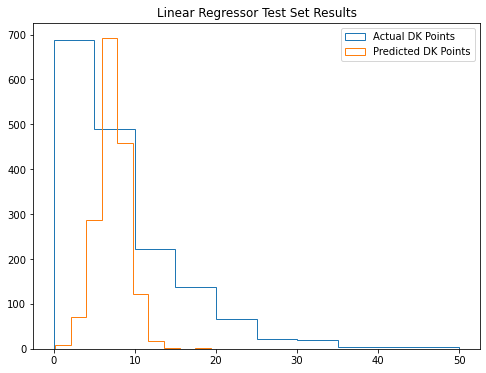

In [804]:
make_hist('Linear Regressor', 'Test')

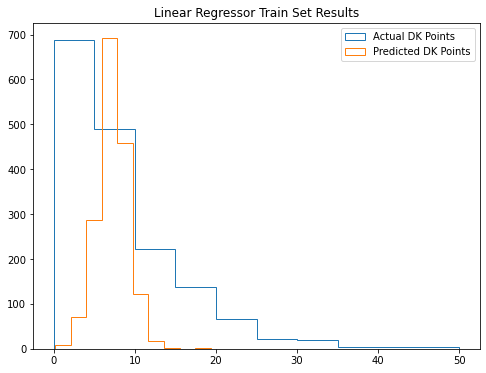

In [805]:
make_hist('Linear Regressor', 'Train')

# Summary
Our Linear Regressor doesn't seem to learn much about the outlying values.

## Lasso regression

In [806]:
from sklearn.linear_model import Lasso

In [807]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.arange(0, 1, .01)}
Lasso_mod = Lasso()
lasso_cv = GridSearchCV(Lasso_mod, param_grid, cv = 5, scoring = 'r2')
lasso_cv.fit(X_train, y_train)
print(f"Best params: {lasso_cv.best_params_}")
print(f"Best score: {lasso_cv.best_score_}")

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75213.05220351717, tolerance: 16.083555483662256
  model = cd_fast.enet_coordinate_descent(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

Best params: {'alpha': 0.18}
Best score: 0.024824426433915116


In [808]:
best_lasso = Lasso(alpha = 0.18)
best_lasso.fit(X_train, y_train)
y_pred = best_lasso.predict(X_test)
print(f"best_lasso R-squared: {best_lasso.score(X_test, y_test)}")
print(f"best_lasso MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"best_lasso RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"best_lasso MSE: {mean_squared_error(y_test, y_pred)}")

best_lasso R-squared: 0.016075157133640494
best_lasso MAE: 5.611997191253945
best_lasso RMSE: 7.479116613258489
best_lasso MSE: 55.93718531471912


In [809]:
best_lasso.score(X_train, y_train)

0.034983386295122654

In [810]:
y_pred.max()

12.07663680917935

In [811]:
print(np.sort(y_pred)[-100:])

[ 8.84092466  8.85611481  8.86403725  8.87728598  8.88814593  8.88893565
  8.88913347  8.89127131  8.89512827  8.90429212  8.90903682  8.91444994
  8.91505437  8.91781853  8.92118928  8.92372683  8.92743463  8.93124086
  8.94738916  8.95542865  8.95838054  8.9622307   8.96251685  8.97151994
  8.97226304  8.97484072  8.98883898  8.9894064   8.99309388  8.99325991
  9.00029007  9.00319111  9.00373911  9.00457911  9.01541719  9.02119637
  9.02563719  9.07377038  9.10063583  9.10783701  9.14199181  9.15519412
  9.16327219  9.1696333   9.17244652  9.18092112  9.181109    9.20206346
  9.20411836  9.26692484  9.31308809  9.32078315  9.35250872  9.35515772
  9.35838754  9.37747114  9.39654425  9.40233277  9.43199291  9.44521978
  9.44637231  9.45679092  9.45790963  9.46227597  9.49211723  9.5076138
  9.53173717  9.54609579  9.55109483  9.56168424  9.59515661  9.60186497
  9.64437374  9.70376705  9.70713236  9.71219356  9.73695666  9.74949006
  9.76985882  9.78302354  9.8134731   9.82837471  9.

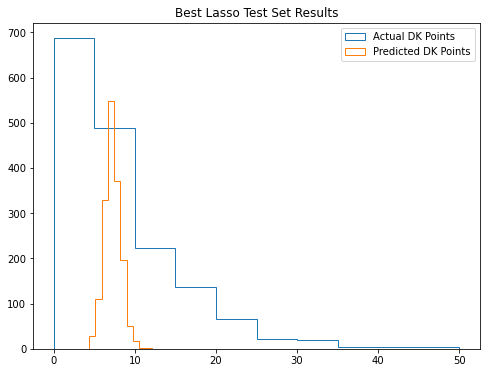

In [812]:
make_hist('Best Lasso', 'Test')

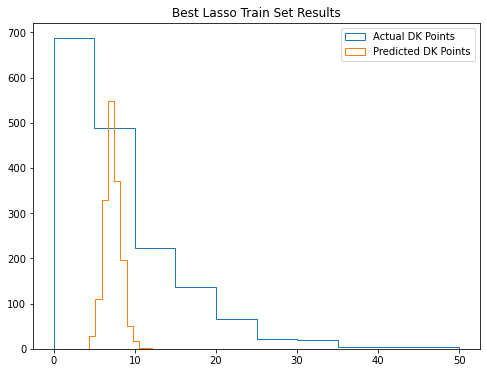

In [813]:
make_hist('Best Lasso', 'Train')

# This is even worse
Not only does our Lasso Regressor fail to predict 14-point scorers, it also doesn't make any predictions lower than about 5 points. The MAE, MSE and RMSE might be slightly better, but not only does this model not predict any outlying values, it also doesn't predict any 0-point scorers. There's value in accurately predicting 0-point scorers so we know which players to avoid, and this model doesn't even try to do that.

# Random Forest
Let's start with default parameters

In [814]:
from sklearn.ensemble import RandomForestRegressor

In [815]:
Base_rf = RandomForestRegressor(random_state = 77)
Base_rf.fit(X_train, y_train)
y_pred = Base_rf.predict(X_test)
print(f"Base Random Forest R-squared: {Base_rf.score(X_test, y_test)}")
print(f"Base Random Forest MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Base Random Forest RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Base Random Forest MSE: {mean_squared_error(y_test, y_pred)}")

Base Random Forest R-squared: 0.004255894331727461
Base Random Forest MAE: 5.683089921544961
Base Random Forest RMSE: 7.5239034492782775
Base Random Forest MSE: 56.60912311406156


In [816]:
Base_rf.score(X_train, y_train)

0.8649995418907894

In [817]:
y_pred.max()

20.43

In [818]:
print(np.sort(y_pred)[-100:])

[11.06 11.07 11.08 11.09 11.1  11.14 11.18 11.19 11.19 11.19 11.24 11.28
 11.28 11.28 11.3  11.31 11.33 11.34 11.38 11.39 11.42 11.43 11.43 11.44
 11.44 11.44 11.49 11.5  11.52 11.54 11.56 11.57 11.58 11.58 11.59 11.59
 11.6  11.64 11.79 11.86 11.87 11.93 11.94 12.01 12.06 12.09 12.09 12.11
 12.16 12.23 12.28 12.29 12.33 12.34 12.37 12.39 12.42 12.56 12.57 12.59
 12.6  12.61 12.64 12.69 12.7  12.7  12.73 12.78 12.78 12.87 12.91 12.92
 12.96 12.97 13.03 13.07 13.22 13.28 13.3  13.64 13.65 13.77 13.85 13.91
 13.98 14.44 14.59 14.87 14.88 15.12 15.42 15.55 15.63 16.57 16.57 16.82
 16.86 17.39 20.34 20.43]


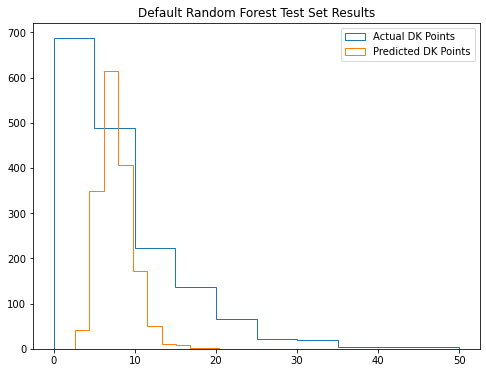

In [819]:
make_hist('Default Random Forest', 'Test')

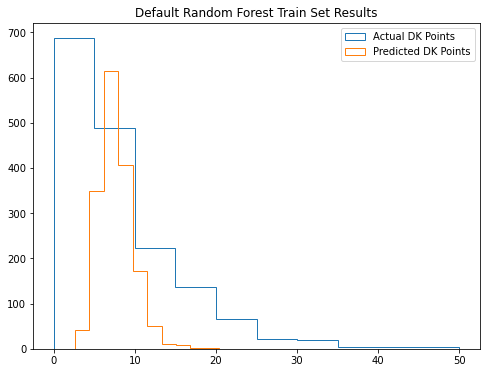

In [820]:
make_hist('Default Random Forest', 'Train')

# A step in the right direction?
The MAE, MSE and RMSE fall off slightly from Lasso, but at least this model is trying to learn the outliers. It makes 21 predictions (rounding up) of 14 or more points. Let's see how good these predictions are with a dataframe.

In [821]:
test_list = list(y_test)

In [822]:
pred_list = list(y_pred)

In [823]:
my_dict = {'Actual':test_list, 'Predicted':pred_list}

In [824]:
model_df = pd.DataFrame(my_dict)

In [825]:
model_df.head()

,Actual,Predicted
0,9,8.27
1,5,7.06
2,0,6.49
3,0,5.47
4,12,8.98


In [826]:
preds14_or_more = model_df.sort_values(by = 'Predicted', ascending = False).iloc[:21, :]

In [830]:
preds14_or_more.head()

,Actual,Predicted
405,4,20.43
1026,5,20.34
521,20,17.39
1017,31,16.86
1526,16,16.82


In [828]:
np.sum(preds14_or_more['Actual'] >= 14)

8

Out of the 21 predictions of 14 or more DK points, only 8 players reach the 14-point threshold. We'll have to keep pushing.

# Tuned Random Forest
We ran a cross-validation grid earlier and it crashed our computer, so to be honest we're a little gun shy about doing it again. So instead we sort of tuned paramaters by hand. The best performance seemed to come from a model with 3500 learners, a max depth of 6 and a max features of square root.

In [831]:
#from sklearn.model_selection import cross_val_score
start = time.time()
rf = RandomForestRegressor(n_estimators = 3500, max_depth = 6, max_features = 'sqrt', random_state = 77, \
                              n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Random Forest Test R2 Score: {rf.score(X_test, y_test)}")
print(f"Random Forest Train R2 Score: {rf.score(X_train, y_train)}")
print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred)}")
end = time.time()
print(f"Run time: {end - start}")

Random Forest Test R2 Score: 0.02270252114644533
Random Forest Train R2 Score: 0.1808832230309496
Random Forest MAE: 5.586278998438638
Random Forest RMSE: 7.453885734588273
Random Forest MSE: 55.560412544298565
Run time: 9.210184335708618


In [832]:
y_pred.max()

15.587351476140384

In [833]:
print(np.sort(y_pred)[-100:])

[ 8.79453299  8.79589139  8.79774814  8.80430068  8.80805596  8.80839131
  8.81038226  8.81244725  8.8300446   8.83338147  8.84530891  8.85541273
  8.85610479  8.8565314   8.8621765   8.86783484  8.87813224  8.89415843
  8.89883173  8.90390096  8.90947732  8.91809808  8.92440112  8.9316763
  8.93390388  8.93516001  8.9402505   8.94030173  8.95467347  8.97498467
  8.97703731  8.97772039  8.98046446  8.98375739  9.024414    9.02902056
  9.04328643  9.0585436   9.08529694  9.09117719  9.09220621  9.10265624
  9.11455996  9.13753465  9.14044106  9.182203    9.18272156  9.18428076
  9.18550003  9.20231586  9.20857744  9.2298255   9.23525219  9.23771023
  9.27133935  9.29238579  9.32648216  9.33140134  9.33457369  9.34019373
  9.34120044  9.34614407  9.35237824  9.35784041  9.36351659  9.38308807
  9.40510345  9.42045831  9.42331435  9.44788141  9.46059123  9.4718155
  9.47229062  9.47505568  9.4751008   9.51584045  9.51626839  9.56198348
  9.59148021  9.62926755  9.96061274  9.96564857 10.1

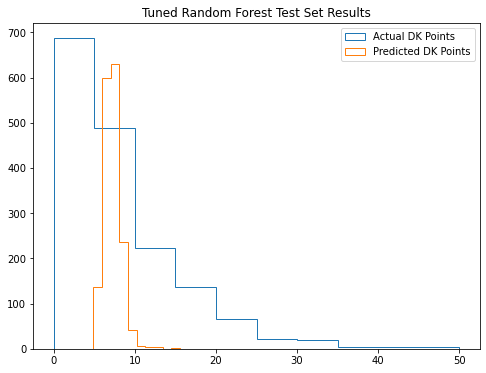

In [834]:
make_hist('Tuned Random Forest', 'Test')

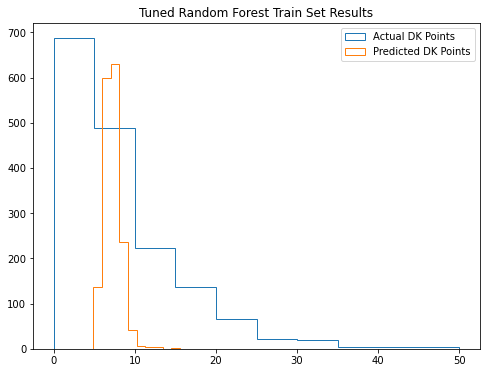

In [835]:
make_hist('Tuned Random Forest', 'Train')

# Time for Gradient Boost
It's not even worth making a dataframe here. Only one prediction over 14 points.<br>

Once again, we kind of tuned our Gradient Boost by hand.<br>

In [836]:
from sklearn.ensemble import GradientBoostingRegressor

In [837]:
start = time.time()
gb = GradientBoostingRegressor(n_estimators = 625, learning_rate = 0.01, max_depth = 6,\
                                  max_features = 'sqrt', random_state = 77)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(f"Gradient Boost R2 Train Score: {gb.score(X_train, y_train)}")
print(f"Gradient Boost R2 Test Score: {gb.score(X_test, y_test)}")
print(f"Gradient Boost MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Gradient Boost RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"Gradient Boost MSE: {mean_squared_error(y_test, y_pred)}")
end = time.time()
print(f"Run time: {end-start}")

Gradient Boost R2 Train Score: 0.6002535156420279
Gradient Boost R2 Test Score: 0.030630834068392176
Gradient Boost MAE: 5.543954658472386
Gradient Boost RMSE: 7.423589389877709
Gradient Boost MSE: 55.1096794295049
Run time: 9.75773286819458


In [838]:
y_pred.max()

20.4802962118282

In [839]:
print(np.sort(y_pred)[-100:])

[10.55146162 10.56838489 10.58295163 10.59626947 10.60233109 10.6152876
 10.62753047 10.67026817 10.71530571 10.7587563  10.76940111 10.80008981
 10.81383359 10.82572213 10.83481389 10.85548456 10.85855392 10.86263482
 10.87029389 10.87409701 10.88034354 10.91473897 10.93508502 10.96139908
 11.00139433 11.00463133 11.06461327 11.07949127 11.08128776 11.11559607
 11.11627452 11.12154395 11.13261542 11.15181186 11.20140127 11.22301389
 11.22501167 11.26235765 11.27823107 11.28165861 11.28389221 11.29964077
 11.321935   11.33208597 11.36586214 11.39849829 11.41853284 11.43870636
 11.45880613 11.4629834  11.48630653 11.51223374 11.54679681 11.54767228
 11.55280807 11.5693753  11.62385123 11.66280929 11.70795819 11.72277626
 11.76373636 11.84011922 11.95234162 12.05430226 12.09931765 12.10938456
 12.11176027 12.18215451 12.21024892 12.30435865 12.33187597 12.3686755
 12.43649433 12.53968174 12.58675753 12.61849879 12.75215813 12.79455149
 12.82759491 12.92735547 13.00725701 13.17743861 13.3

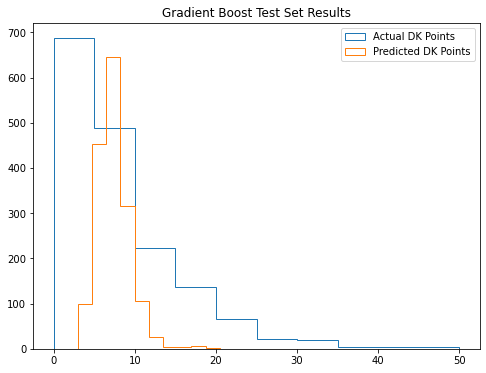

In [840]:
make_hist('Gradient Boost', 'Test')

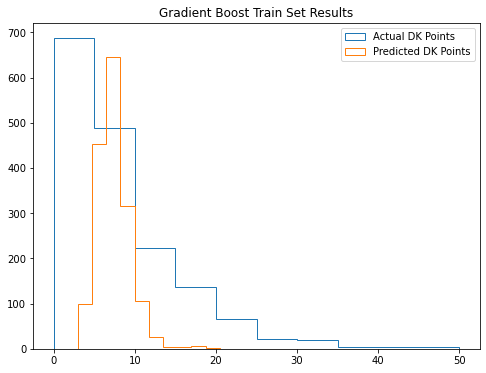

In [841]:
make_hist('Gradient Boost', 'Train')

In [842]:
test_list = list(y_test)

In [843]:
pred_list = list(y_pred)

In [844]:
my_dict = {'Actual':test_list, 'Predicted':pred_list}

In [845]:
gb_df = pd.DataFrame(my_dict)

In [846]:
preds14_or_more = gb_df.sort_values(by = 'Predicted', ascending = False).iloc[:14, :]

In [847]:
np.sum(preds14_or_more['Actual'] > 14)

6

# Time for XGBoost
Here's where we started with simple LinearRegressor:<br>

Baseline_reg R-squared: 0.0011366877415929233<br>
Baseline_reg train R-squared: 0.06296989455787483<br>
Baseline_reg MAE: 5.68589808866391<br>
Baseline_reg RMSE: 7.5356786929075525<br>
Baseline_reg MSE: 56.78645336274088<br>

Here's where we are now with Gradient Boost:<br>

Gradient Boost R2 Train Score: 0.6002535156420279<br>
Gradient Boost R2 Test Score: 0.030630834068392176<br>
Gradient Boost MAE: 5.543954658472386<br>
Gradient Boost RMSE: 7.423589389877709<br>
Gradient Boost MSE: 55.1096794295049<br>

Like the default Random Forest, Gradient Boost at least takes a shot at predicting the big hitters. But there's no improvement over Random Forest when it comes to our handmade 14-or-over metric. Again, we're looking at how many predictions of 14 or more match up with actual scores of 14 or more. Random Forest was right in 8 out of 21 times. This model is right 6 out of 15 times. And neither of these models are predicting enough high scores in proportion to actual high scores.<br>

XGBoost, you're up..<br>

Here, we will cross validate<br>

In [849]:
dk_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
params = {'objective': 'reg:linear', 'max_depth': 3}
l1_params = [1, 10, 54]
rmses_l1 = []

In [850]:
start = time.time()
for reg in l1_params:
    params['alpha'] = reg
    cv_results = xgb.cv(dtrain = dk_dmatrix, params = params, nfold = 5, num_boost_round = 12, metrics = 'rmse',\
                       as_pandas = True, seed = 77)
    rmses_l1.append(cv_results['test-rmse-mean'].tail(1).values[0])
print("Best RMSE as a function of l1:")
print(pd.DataFrame(list(zip(l1_params, rmses_l1)), columns = ['l1', 'rmse']))
start = time.time()
print(f"Run time: {end - start} seconds")

[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:15] WARNING: d:\bld\xgboost-split_1637426510059\work\src\

So we got the RMSE from 7.42 to 7.07. Let's try the tuned XGBoost model on the test set.

In [851]:
best_xgb = xgb.XGBRegressor(objective = 'reg:linear', reg_lambda = 54, max_depth = 3, n_estimators = 12, seed = 77)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print(f"XG Boost R2 Train Score: {best_xgb.score(X_train, y_train)}")
print(f"XG Boost R2 Test Score: {best_xgb.score(X_test, y_test)}")
print(f"XG Boost MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"XG Boost RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")
print(f"XG Boost MSE: {mean_squared_error(y_test, y_pred)}")

[16:12:57] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
XG Boost R2 Train Score: 0.12742311293277875
XG Boost R2 Test Score: 0.017405622821811573
XG Boost MAE: 5.528773102331535
XG Boost RMSE: 7.474058262397967
XG Boost MSE: 55.861546909719316


In [852]:
#l1 = 54, max depth = 3, num boost round = 12 rmse = 7.069928

In [853]:
y_pred.max()

11.418595

<a href='#contents'>Back to Table of Contents</a>

<a id='Classification Models'></a>

# Time for classification
More of the same here. XG Boost doesn't predict anything close to 14 and none of these models have a test-set R-squared score that's much better than 0. We probably should have known this going in, but there are not yet any humans or machines that can reliably predict points for hitters in daily fantasy baseball.<br>

So we will instead focus on trying to predict whether or not a player will simply hit at least one home run in that day's game.<br>

If we can come up with an acceptable model for this target variable, it will have value because as we said earlier, a home run guarantees 14 points and 14 points from each hitter will help you in most cash games as long as your pitching doesn't flop. While it's tempting to go for the big pile of money in guaranteed-prize-pool (GPP) tournaments, cash games are the foundation of success in daily fantasy sports. If you can achieve about a 60 percent success rate in these games where you either double your money or win 18 dollars on a 10-dollar entry fee (for example), you will turn a profit and eventually have enough of a bankroll to enter more GPPs and go for the big win.<br>

We would need to couple this model with an accurate regression model for pitching, where the distribution is more normal. Let's do the hard part first and try to come up with a classification model for home runs.<br>

# Histogram
Just to visualize our point, here's a histogram of DraftKings points for each hitter with at least one home run. It pretty much mirrors the distribution for the entire dataset, but instead of 0, the floor is 14.

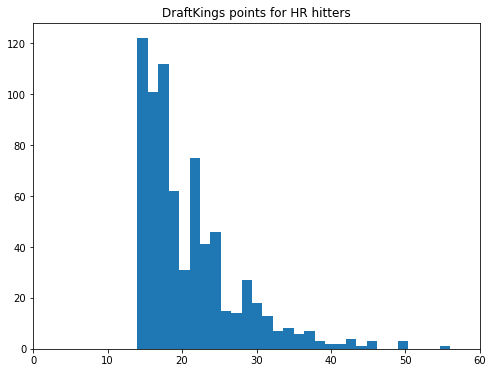

In [863]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(main_df_true['DK_Pts'], label = 'DK Points', bins = 30)
ax.set_xlim(0, 60)
ax.set_title('DraftKings points for HR hitters')
plt.show()

# Let's just go right to XGBoost
Actually, we didn't go straight to XGBoost. We first tried bare-bones Logistic Regression and then default Random Forest. LogReg just predicted False for everything, as there are 4797 False values and 724 True values, and Random Forest predicted one True value that was actually False. The results were so bad that we went back to regression one more time. THEN we went to XGBoost for classification. The Logistic Regression and Random Forest code are at the bottom of the notebook.<br>

We'll start XGBoost with tuning by hand.<br>

In [600]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
xgb_class = xgb.XGBClassifier(learning_rate = 0.9, max_depth = 6, n_estimators = 800, seed = 7)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
print("Accuracy on training set:", xgb_class.score(X_train, y_train))
print("Accuracy on test set:", xgb_class.score(X_test, y_test))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 1.0
Accuracy on test set: 0.8485214242607121
Confusion matrix:
[[1395   56]
 [ 195   11]]
Classification report:
              precision    recall  f1-score   support

       False       0.88      0.96      0.92      1451
        True       0.16      0.05      0.08       206

    accuracy                           0.85      1657
   macro avg       0.52      0.51      0.50      1657
weighted avg       0.79      0.85      0.81      1657



# Imbalanced classes
Because of the class imbalance, our model is having difficulty learning the True samples, as evidenced by the Recall of 0.05 for the True values.<br>

We'll adjust the scale_pos_weight paramater and see where that gets us.<br>

In [601]:
xgb_class = xgb.XGBClassifier(learning_rate = 0.9, max_depth = 9, scale_pos_weight = 1000, n_estimators = 800, seed = 144)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
print("Accuracy on training set:", xgb_class.score(X_train, y_train))
print("Accuracy on test set:", xgb_class.score(X_test, y_test))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

[17:58:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 1.0
Accuracy on test set: 0.7573928786964393
Confusion matrix:
[[1203  248]
 [ 154   52]]
Classification report:
              precision    recall  f1-score   support

       False       0.89      0.83      0.86      1451
        True       0.17      0.25      0.21       206

    accuracy                           0.76      1657
   macro avg       0.53      0.54      0.53      1657
weighted avg       0.80      0.76      0.78      1657



# Still not good, but better
Accuracy has gone from 85 percent to 75 percent but Recall for the True label has gone up to 0.2.5 We're willing to sacrifice overall accuracy if we can come up with a model that more often than not can detect whether a player will hit a home run in a given game. We did a lot of parameter tuning by hand but could not get the True Recall higher than 0.25.<br>

So we imported the SMOTE library, which creates synthetic samples of the minority class based an data from the actual minority class.<br>

In [602]:
from imblearn.over_sampling import SMOTE

In [603]:
from collections import Counter

In [604]:
counter = Counter(y)
print(counter)

Counter({False: 4797, True: 724})


In [605]:
oversample = SMOTE()

In [606]:
X, y = oversample.fit_resample(X, y)

In [607]:
counter = Counter(y)
print(counter)

Counter({True: 4797, False: 4797})


In [618]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [619]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# The home (run) stretch
Now, with a balanced dataset, we'll take a shot at parameter tuning the way the pros do it. Using just our training set, we'll do 3-fold cross validation.

In [620]:
param_grid = {'learning_rate' : [0.1, 0.3, 0.6, 0.9], 'max_depth': [12, 15], 'colsample_bytree': [0.1, 1]}
xgbclass_tuned = xgb.XGBClassifier(n_estimators = 800, random_state = 7)

In [621]:
from sklearn.model_selection import GridSearchCV
cv_search = GridSearchCV(estimator = xgbclass_tuned, param_grid=param_grid, scoring = 'recall', cv=3, n_jobs = 2,\
                         verbose = 3)
cv_search.fit(X_train, y_train)
print(f"Best score: {cv_search.best_score_}")
print(f"Best params: {cv_search.best_params_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  8.3min finished
C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.8714654751284993
Best params: {'colsample_bytree': 0.1, 'learning_rate': 0.9, 'max_depth': 12}


# Testing time
We'll take those best params and try it on the final holdout data, our test set.

In [624]:
xgbclass_tuned = xgb.XGBClassifier(n_estimators = 800, learning_rate = 0.9, max_depth = 12, colsample_bytree = 0.1, \
                                   random_state = 7)
xgbclass_tuned.fit(X_train, y_train)
y_pred = xgbclass_tuned.predict(X_test)
print("Accuracy on training set:", xgbclass_tuned.score(X_train, y_train))
print("Accuracy on test set:", xgbclass_tuned.score(X_test, y_test))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

[19:25:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set: 1.0
Accuracy on test set: 0.919763806877388
Confusion matrix:
[[1385   58]
 [ 173 1263]]
Classification report:
              precision    recall  f1-score   support

       False       0.89      0.96      0.92      1443
        True       0.96      0.88      0.92      1436

    accuracy                           0.92      2879
   macro avg       0.92      0.92      0.92      2879
weighted avg       0.92      0.92      0.92      2879



So based on recall for the True and False labels, this model detects 88 percent of home run hitters and 96 percent of non-home run hitters. When this is deployed live, we'd be happy even with 75 percent recall for the True label. Since a DraftKings lineup consists of eight hitters, theoretically 75 percent recall should get you six home runs most of the time. That's at least 84 points, add 60 to that if you get respectable performances from both of your pitchers, and you can win a lot of cash games.<br>

Now let's look at the ROC Curve and the AUC score.<br>

In [627]:
from sklearn.metrics import auc, roc_curve

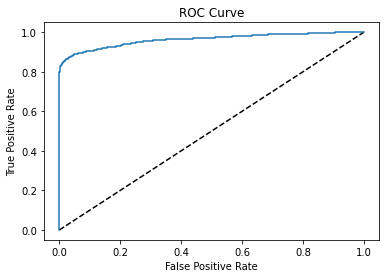

In [634]:
y_pred_prob = xgbclass_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'True')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()

In [635]:
from sklearn.metrics import roc_auc_score

In [637]:
roc_auc_score(y_test, y_pred_prob)

0.9627690686186507

That's a rather L-shaped curve. Taking a quick peek at just a few of the probabilities, most of them are over 99 percent and under 1 percent. That could explan the shape of the curve.

<a href = 'contents'>Back to Table of Contents</a>

<a id = '#conclusion'></a>

# Conclusion
In the real world, this model will have to perform on unbalanced test data. Perhaps the artificial balancing can be performed on that also. As we said we'll be ok with a recall slippage to 0.75 or so for the True label.

Spring training is over for this model. Now it's time to play ball.

# Our first attempts at classification

In [985]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification report:")
print(classification_report(y_test, y_pred))

Confusion matrix:
[[1430    0]
 [ 227    0]]

Classification report:
              precision    recall  f1-score   support

       False       0.86      1.00      0.93      1430
        True       0.00      0.00      0.00       227

    accuracy                           0.86      1657
   macro avg       0.43      0.50      0.46      1657
weighted avg       0.74      0.86      0.80      1657



C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [989]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

In [990]:
# Plug in appropriate max_depth and random_state parameters 
firstRFModel = RandomForestClassifier() 

# Model and fit
firstRFModel.fit(X_train, y_train) 

y_pred = firstRFModel.predict(X_test)

In [993]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification report:")
print(classification_report(y_test, y_pred))

Confusion matrix:
[[1429    1]
 [ 227    0]]

Classification report:
              precision    recall  f1-score   support

       False       0.86      1.00      0.93      1430
        True       0.00      0.00      0.00       227

    accuracy                           0.86      1657
   macro avg       0.43      0.50      0.46      1657
weighted avg       0.74      0.86      0.80      1657

